In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1418448, 828)
(1418448, 1)
validation
(214736, 828)
(214736, 1)
test
(156944, 828)
(156944, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/142 [..............................] - ETA: 3:42 - loss: 0.0898 - STD: 1.8352e-04 - MAE: 0.2881

  4/142 [..............................] - ETA: 4s - loss: 0.0399 - STD: 3.9822e-04 - MAE: 0.1557  

  5/142 [>.............................] - ETA: 5s - loss: 0.0397 - STD: 3.5844e-04 - MAE: 0.1568

  6/142 [>.............................] - ETA: 6s - loss: 0.0395 - STD: 3.2805e-04 - MAE: 0.1574

  7/142 [>.............................] - ETA: 6s - loss: 0.0390 - STD: 3.1107e-04 - MAE: 0.1566

  8/142 [>.............................] - ETA: 6s - loss: 0.0378 - STD: 3.0637e-04 - MAE: 0.1535

  9/142 [>.............................] - ETA: 7s - loss: 0.0363 - STD: 3.1267e-04 - MAE: 0.1486

 10/142 [=>............................] - ETA: 7s - loss: 0.0344 - STD: 3.2656e-04 - MAE: 0.1416

 11/142 [=>............................] - ETA: 7s - loss: 0.0325 - STD: 3.4541e-04 - MAE: 0.1344

 12/142 [=>............................] - ETA: 7s - loss: 0.0308 - STD: 3.6607e-04 - MAE: 0.1294

 13/142 [=>............................] - ETA: 7s - loss: 0.0295 - STD: 3.8690e-04 - MAE: 0.1272

 14/142 [=>............................] - ETA: 7s - loss: 0.0287 - STD: 4.0684e-04 - MAE: 0.1267

 15/142 [==>...........................] - ETA: 7s - loss: 0.0282 - STD: 4.2530e-04 - MAE: 0.1269

 16/142 [==>...........................] - ETA: 7s - loss: 0.0276 - STD: 4.4263e-04 - MAE: 0.1267

 17/142 [==>...........................] - ETA: 7s - loss: 0.0270 - STD: 4.5898e-04 - MAE: 0.1259

 18/142 [==>...........................] - ETA: 7s - loss: 0.0263 - STD: 4.7355e-04 - MAE: 0.1242

 19/142 [===>..........................] - ETA: 7s - loss: 0.0256 - STD: 4.8738e-04 - MAE: 0.1220

 20/142 [===>..........................] - ETA: 7s - loss: 0.0250 - STD: 4.9959e-04 - MAE: 0.1194

 21/142 [===>..........................] - ETA: 7s - loss: 0.0244 - STD: 5.1011e-04 - MAE: 0.1167

 22/142 [===>..........................] - ETA: 7s - loss: 0.0239 - STD: 5.1977e-04 - MAE: 0.1143

 23/142 [===>..........................] - ETA: 7s - loss: 0.0236 - STD: 5.2940e-04 - MAE: 0.1122

 24/142 [====>.........................] - ETA: 7s - loss: 0.0233 - STD: 5.3930e-04 - MAE: 0.1105

 25/142 [====>.........................] - ETA: 7s - loss: 0.0229 - STD: 5.4987e-04 - MAE: 0.1088

 26/142 [====>.........................] - ETA: 7s - loss: 0.0226 - STD: 5.6122e-04 - MAE: 0.1071

 27/142 [====>.........................] - ETA: 7s - loss: 0.0223 - STD: 5.7420e-04 - MAE: 0.1055

 28/142 [====>.........................] - ETA: 7s - loss: 0.0220 - STD: 5.8852e-04 - MAE: 0.1041

 29/142 [=====>........................] - ETA: 7s - loss: 0.0217 - STD: 6.0442e-04 - MAE: 0.1029

 30/142 [=====>........................] - ETA: 7s - loss: 0.0214 - STD: 6.2152e-04 - MAE: 0.1019

 31/142 [=====>........................] - ETA: 7s - loss: 0.0211 - STD: 6.3999e-04 - MAE: 0.1012

 32/142 [=====>........................] - ETA: 6s - loss: 0.0209 - STD: 6.5981e-04 - MAE: 0.1007

 33/142 [=====>........................] - ETA: 6s - loss: 0.0207 - STD: 6.8038e-04 - MAE: 0.1004

 34/142 [======>.......................] - ETA: 6s - loss: 0.0205 - STD: 7.0127e-04 - MAE: 0.1000

 35/142 [======>.......................] - ETA: 6s - loss: 0.0203 - STD: 7.2281e-04 - MAE: 0.0997

 36/142 [======>.......................] - ETA: 6s - loss: 0.0201 - STD: 7.4459e-04 - MAE: 0.0992

 37/142 [======>.......................] - ETA: 6s - loss: 0.0199 - STD: 7.6671e-04 - MAE: 0.0987

 38/142 [=======>......................] - ETA: 6s - loss: 0.0197 - STD: 7.8916e-04 - MAE: 0.0980

 39/142 [=======>......................] - ETA: 6s - loss: 0.0195 - STD: 8.1143e-04 - MAE: 0.0973

 40/142 [=======>......................] - ETA: 6s - loss: 0.0193 - STD: 8.3490e-04 - MAE: 0.0966

 41/142 [=======>......................] - ETA: 6s - loss: 0.0191 - STD: 8.5762e-04 - MAE: 0.0957

 42/142 [=======>......................] - ETA: 6s - loss: 0.0190 - STD: 8.8300e-04 - MAE: 0.0951

 43/142 [========>.....................] - ETA: 6s - loss: 0.0189 - STD: 9.0855e-04 - MAE: 0.0943

 44/142 [========>.....................] - ETA: 6s - loss: 0.0187 - STD: 9.3689e-04 - MAE: 0.0937

 45/142 [========>.....................] - ETA: 6s - loss: 0.0186 - STD: 9.6594e-04 - MAE: 0.0931

 46/142 [========>.....................] - ETA: 6s - loss: 0.0185 - STD: 9.9697e-04 - MAE: 0.0925

 47/142 [========>.....................] - ETA: 6s - loss: 0.0183 - STD: 0.0010 - MAE: 0.0920    

 48/142 [=========>....................] - ETA: 6s - loss: 0.0182 - STD: 0.0011 - MAE: 0.0916

 49/142 [=========>....................] - ETA: 6s - loss: 0.0181 - STD: 0.0011 - MAE: 0.0913

 50/142 [=========>....................] - ETA: 5s - loss: 0.0180 - STD: 0.0011 - MAE: 0.0910

 51/142 [=========>....................] - ETA: 5s - loss: 0.0179 - STD: 0.0012 - MAE: 0.0907

 52/142 [=========>....................] - ETA: 5s - loss: 0.0177 - STD: 0.0012 - MAE: 0.0904

 53/142 [==========>...................] - ETA: 5s - loss: 0.0176 - STD: 0.0013 - MAE: 0.0901

 54/142 [==========>...................] - ETA: 5s - loss: 0.0175 - STD: 0.0013 - MAE: 0.0898

 55/142 [==========>...................] - ETA: 5s - loss: 0.0175 - STD: 0.0014 - MAE: 0.0895

 56/142 [==========>...................] - ETA: 5s - loss: 0.0174 - STD: 0.0014 - MAE: 0.0891

 57/142 [===========>..................] - ETA: 5s - loss: 0.0173 - STD: 0.0015 - MAE: 0.0888

 58/142 [===========>..................] - ETA: 5s - loss: 0.0172 - STD: 0.0016 - MAE: 0.0884

 59/142 [===========>..................] - ETA: 5s - loss: 0.0171 - STD: 0.0016 - MAE: 0.0881

 60/142 [===========>..................] - ETA: 5s - loss: 0.0170 - STD: 0.0017 - MAE: 0.0877

 61/142 [===========>..................] - ETA: 5s - loss: 0.0169 - STD: 0.0018 - MAE: 0.0873

 62/142 [============>.................] - ETA: 5s - loss: 0.0168 - STD: 0.0019 - MAE: 0.0870

 63/142 [============>.................] - ETA: 5s - loss: 0.0168 - STD: 0.0020 - MAE: 0.0867

 64/142 [============>.................] - ETA: 5s - loss: 0.0167 - STD: 0.0021 - MAE: 0.0864

 65/142 [============>.................] - ETA: 5s - loss: 0.0166 - STD: 0.0022 - MAE: 0.0862

 66/142 [============>.................] - ETA: 4s - loss: 0.0165 - STD: 0.0023 - MAE: 0.0860

 67/142 [=============>................] - ETA: 4s - loss: 0.0165 - STD: 0.0024 - MAE: 0.0857

 68/142 [=============>................] - ETA: 4s - loss: 0.0164 - STD: 0.0025 - MAE: 0.0855

 69/142 [=============>................] - ETA: 4s - loss: 0.0163 - STD: 0.0027 - MAE: 0.0853

 70/142 [=============>................] - ETA: 4s - loss: 0.0162 - STD: 0.0028 - MAE: 0.0850

 71/142 [==============>...............] - ETA: 4s - loss: 0.0162 - STD: 0.0030 - MAE: 0.0848

 72/142 [==============>...............] - ETA: 4s - loss: 0.0161 - STD: 0.0032 - MAE: 0.0845

 73/142 [==============>...............] - ETA: 4s - loss: 0.0160 - STD: 0.0034 - MAE: 0.0842

 74/142 [==============>...............] - ETA: 4s - loss: 0.0159 - STD: 0.0036 - MAE: 0.0839

 75/142 [==============>...............] - ETA: 4s - loss: 0.0158 - STD: 0.0038 - MAE: 0.0836

 76/142 [===============>..............] - ETA: 4s - loss: 0.0157 - STD: 0.0041 - MAE: 0.0832

 77/142 [===============>..............] - ETA: 4s - loss: 0.0157 - STD: 0.0043 - MAE: 0.0829

 78/142 [===============>..............] - ETA: 4s - loss: 0.0156 - STD: 0.0046 - MAE: 0.0826

 79/142 [===============>..............] - ETA: 4s - loss: 0.0155 - STD: 0.0050 - MAE: 0.0823

 80/142 [===============>..............] - ETA: 4s - loss: 0.0154 - STD: 0.0053 - MAE: 0.0821

 81/142 [================>.............] - ETA: 4s - loss: 0.0153 - STD: 0.0057 - MAE: 0.0817

 82/142 [================>.............] - ETA: 3s - loss: 0.0152 - STD: 0.0061 - MAE: 0.0814

 83/142 [================>.............] - ETA: 3s - loss: 0.0151 - STD: 0.0065 - MAE: 0.0811

 84/142 [================>.............] - ETA: 3s - loss: 0.0150 - STD: 0.0070 - MAE: 0.0808

 85/142 [================>.............] - ETA: 3s - loss: 0.0149 - STD: 0.0075 - MAE: 0.0804

 86/142 [=================>............] - ETA: 3s - loss: 0.0148 - STD: 0.0080 - MAE: 0.0801

 87/142 [=================>............] - ETA: 3s - loss: 0.0147 - STD: 0.0085 - MAE: 0.0797

 88/142 [=================>............] - ETA: 3s - loss: 0.0146 - STD: 0.0091 - MAE: 0.0793

 89/142 [=================>............] - ETA: 3s - loss: 0.0145 - STD: 0.0097 - MAE: 0.0790

 90/142 [==================>...........] - ETA: 3s - loss: 0.0144 - STD: 0.0104 - MAE: 0.0786

 91/142 [==================>...........] - ETA: 3s - loss: 0.0143 - STD: 0.0110 - MAE: 0.0783

 92/142 [==================>...........] - ETA: 3s - loss: 0.0142 - STD: 0.0117 - MAE: 0.0779

 93/142 [==================>...........] - ETA: 3s - loss: 0.0141 - STD: 0.0123 - MAE: 0.0775

 94/142 [==================>...........] - ETA: 3s - loss: 0.0140 - STD: 0.0130 - MAE: 0.0772

 95/142 [===================>..........] - ETA: 3s - loss: 0.0139 - STD: 0.0137 - MAE: 0.0768

 96/142 [===================>..........] - ETA: 3s - loss: 0.0138 - STD: 0.0144 - MAE: 0.0765

 97/142 [===================>..........] - ETA: 2s - loss: 0.0137 - STD: 0.0151 - MAE: 0.0761

 98/142 [===================>..........] - ETA: 2s - loss: 0.0136 - STD: 0.0159 - MAE: 0.0757

 99/142 [===================>..........] - ETA: 2s - loss: 0.0135 - STD: 0.0166 - MAE: 0.0754

100/142 [====================>.........] - ETA: 2s - loss: 0.0134 - STD: 0.0173 - MAE: 0.0751

101/142 [====================>.........] - ETA: 2s - loss: 0.0133 - STD: 0.0180 - MAE: 0.0747

102/142 [====================>.........] - ETA: 2s - loss: 0.0132 - STD: 0.0187 - MAE: 0.0744

103/142 [====================>.........] - ETA: 2s - loss: 0.0131 - STD: 0.0193 - MAE: 0.0741

104/142 [====================>.........] - ETA: 2s - loss: 0.0130 - STD: 0.0200 - MAE: 0.0737

105/142 [=====================>........] - ETA: 2s - loss: 0.0130 - STD: 0.0207 - MAE: 0.0734

106/142 [=====================>........] - ETA: 2s - loss: 0.0129 - STD: 0.0213 - MAE: 0.0731

107/142 [=====================>........] - ETA: 2s - loss: 0.0128 - STD: 0.0220 - MAE: 0.0728

108/142 [=====================>........] - ETA: 2s - loss: 0.0127 - STD: 0.0227 - MAE: 0.0725

109/142 [======================>.......] - ETA: 2s - loss: 0.0126 - STD: 0.0233 - MAE: 0.0722

110/142 [======================>.......] - ETA: 2s - loss: 0.0125 - STD: 0.0240 - MAE: 0.0719

111/142 [======================>.......] - ETA: 2s - loss: 0.0125 - STD: 0.0246 - MAE: 0.0716

112/142 [======================>.......] - ETA: 1s - loss: 0.0124 - STD: 0.0252 - MAE: 0.0713

113/142 [======================>.......] - ETA: 1s - loss: 0.0123 - STD: 0.0259 - MAE: 0.0710

114/142 [=======================>......] - ETA: 1s - loss: 0.0122 - STD: 0.0265 - MAE: 0.0708

115/142 [=======================>......] - ETA: 1s - loss: 0.0122 - STD: 0.0271 - MAE: 0.0705

116/142 [=======================>......] - ETA: 1s - loss: 0.0121 - STD: 0.0277 - MAE: 0.0702

117/142 [=======================>......] - ETA: 1s - loss: 0.0120 - STD: 0.0282 - MAE: 0.0700

118/142 [=======================>......] - ETA: 1s - loss: 0.0119 - STD: 0.0288 - MAE: 0.0697

119/142 [========================>.....] - ETA: 1s - loss: 0.0119 - STD: 0.0293 - MAE: 0.0694

120/142 [========================>.....] - ETA: 1s - loss: 0.0118 - STD: 0.0299 - MAE: 0.0692

121/142 [========================>.....] - ETA: 1s - loss: 0.0117 - STD: 0.0304 - MAE: 0.0689

122/142 [========================>.....] - ETA: 1s - loss: 0.0117 - STD: 0.0309 - MAE: 0.0687

123/142 [========================>.....] - ETA: 1s - loss: 0.0116 - STD: 0.0314 - MAE: 0.0684

124/142 [=========================>....] - ETA: 1s - loss: 0.0115 - STD: 0.0319 - MAE: 0.0682

125/142 [=========================>....] - ETA: 1s - loss: 0.0115 - STD: 0.0325 - MAE: 0.0680

126/142 [=========================>....] - ETA: 1s - loss: 0.0114 - STD: 0.0329 - MAE: 0.0677

127/142 [=========================>....] - ETA: 0s - loss: 0.0113 - STD: 0.0334 - MAE: 0.0675

128/142 [==========================>...] - ETA: 0s - loss: 0.0113 - STD: 0.0339 - MAE: 0.0673

129/142 [==========================>...] - ETA: 0s - loss: 0.0112 - STD: 0.0343 - MAE: 0.0671

130/142 [==========================>...] - ETA: 0s - loss: 0.0112 - STD: 0.0348 - MAE: 0.0669

131/142 [==========================>...] - ETA: 0s - loss: 0.0111 - STD: 0.0352 - MAE: 0.0667

132/142 [==========================>...] - ETA: 0s - loss: 0.0111 - STD: 0.0357 - MAE: 0.0664

135/142 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 0.0370 - MAE: 0.0658

137/142 [===========================>..] - ETA: 0s - loss: 0.0108 - STD: 0.0379 - MAE: 0.0654

138/142 [============================>.] - ETA: 0s - loss: 0.0107 - STD: 0.0383 - MAE: 0.0653

139/142 [============================>.] - ETA: 0s - loss: 0.0107 - STD: 0.0387 - MAE: 0.0651

140/142 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 0.0391 - MAE: 0.0649

141/142 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 0.0395 - MAE: 0.0647

142/142 [==============================] - ETA: 0s - loss: 0.0105 - STD: 0.0399 - MAE: 0.0645

142/142 [==============================] - 13s 78ms/step - loss: 0.0105 - STD: 0.0399 - MAE: 0.0645 - val_loss: 0.0037 - val_STD: 0.0712 - val_MAE: 0.0392


Epoch 2/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0034 - STD: 0.0952 - MAE: 0.0385

  2/142 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0948 - MAE: 0.0385 

  3/142 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0954 - MAE: 0.0386

  4/142 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0954 - MAE: 0.0387

  5/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0962 - MAE: 0.0388

  6/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0963 - MAE: 0.0390

  7/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0966 - MAE: 0.0389

  8/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0963 - MAE: 0.0389

  9/142 [>.............................] - ETA: 9s - loss: 0.0035 - STD: 0.0962 - MAE: 0.0389

 10/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0959 - MAE: 0.0388

 11/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0961 - MAE: 0.0388

 12/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0963 - MAE: 0.0388

 13/142 [=>............................] - ETA: 8s - loss: 0.0035 - STD: 0.0964 - MAE: 0.0388

 14/142 [=>............................] - ETA: 8s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0387

 15/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0962 - MAE: 0.0387

 16/142 [==>...........................] - ETA: 8s - loss: 0.0035 - STD: 0.0961 - MAE: 0.0388

 17/142 [==>...........................] - ETA: 8s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0387

 18/142 [==>...........................] - ETA: 8s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0387

 19/142 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0386

 20/142 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0386

 21/142 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0386

 22/142 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0386

 23/142 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0385

 24/142 [====>.........................] - ETA: 7s - loss: 0.0034 - STD: 0.0961 - MAE: 0.0385

 25/142 [====>.........................] - ETA: 7s - loss: 0.0034 - STD: 0.0961 - MAE: 0.0385

 26/142 [====>.........................] - ETA: 7s - loss: 0.0034 - STD: 0.0962 - MAE: 0.0384

 27/142 [====>.........................] - ETA: 7s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0384

 28/142 [====>.........................] - ETA: 7s - loss: 0.0034 - STD: 0.0962 - MAE: 0.0384

 29/142 [=====>........................] - ETA: 7s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0384

 30/142 [=====>........................] - ETA: 7s - loss: 0.0034 - STD: 0.0962 - MAE: 0.0384

 31/142 [=====>........................] - ETA: 7s - loss: 0.0034 - STD: 0.0962 - MAE: 0.0384

 32/142 [=====>........................] - ETA: 7s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0384

 33/142 [=====>........................] - ETA: 7s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0384

 34/142 [======>.......................] - ETA: 7s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0384

 35/142 [======>.......................] - ETA: 7s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0384

 36/142 [======>.......................] - ETA: 7s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0383

 37/142 [======>.......................] - ETA: 6s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0383

 38/142 [=======>......................] - ETA: 6s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0383

 39/142 [=======>......................] - ETA: 6s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0383

 40/142 [=======>......................] - ETA: 6s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0383

 41/142 [=======>......................] - ETA: 6s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0383

 42/142 [=======>......................] - ETA: 6s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0383

 43/142 [========>.....................] - ETA: 6s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0382

 44/142 [========>.....................] - ETA: 6s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0383

 45/142 [========>.....................] - ETA: 6s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0382

 46/142 [========>.....................] - ETA: 6s - loss: 0.0034 - STD: 0.0963 - MAE: 0.0382

 47/142 [========>.....................] - ETA: 6s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0382

 48/142 [=========>....................] - ETA: 6s - loss: 0.0034 - STD: 0.0964 - MAE: 0.0382

 49/142 [=========>....................] - ETA: 6s - loss: 0.0033 - STD: 0.0964 - MAE: 0.0382

 50/142 [=========>....................] - ETA: 6s - loss: 0.0033 - STD: 0.0964 - MAE: 0.0382

 51/142 [=========>....................] - ETA: 6s - loss: 0.0033 - STD: 0.0964 - MAE: 0.0382

 52/142 [=========>....................] - ETA: 6s - loss: 0.0033 - STD: 0.0964 - MAE: 0.0382

 53/142 [==========>...................] - ETA: 5s - loss: 0.0033 - STD: 0.0964 - MAE: 0.0382

 54/142 [==========>...................] - ETA: 5s - loss: 0.0033 - STD: 0.0964 - MAE: 0.0382

 55/142 [==========>...................] - ETA: 5s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0382

 56/142 [==========>...................] - ETA: 5s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0382

 57/142 [===========>..................] - ETA: 5s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0382

 58/142 [===========>..................] - ETA: 5s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0382

 59/142 [===========>..................] - ETA: 5s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0381

 60/142 [===========>..................] - ETA: 5s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0381

 61/142 [===========>..................] - ETA: 5s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0381

 62/142 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0381

 63/142 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0381

 64/142 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0381

 65/142 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0381

 66/142 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0381

 67/142 [=============>................] - ETA: 5s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0381

 68/142 [=============>................] - ETA: 4s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0381

 69/142 [=============>................] - ETA: 4s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0381

 70/142 [=============>................] - ETA: 4s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0381

 71/142 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0381

 72/142 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0380

 73/142 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0380

 74/142 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0380

 75/142 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0380

 76/142 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0966 - MAE: 0.0380

 77/142 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0380

 78/142 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0380

 79/142 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0380

 80/142 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0380

 81/142 [================>.............] - ETA: 4s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0380

 82/142 [================>.............] - ETA: 4s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0380

 83/142 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0380

 84/142 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0380

 85/142 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0379

 86/142 [=================>............] - ETA: 3s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0379

 87/142 [=================>............] - ETA: 3s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0379

 88/142 [=================>............] - ETA: 3s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0379

 89/142 [=================>............] - ETA: 3s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0379

 90/142 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0379

 91/142 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0379

 92/142 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0379

 93/142 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0379

 94/142 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0379

 95/142 [===================>..........] - ETA: 3s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0379

 96/142 [===================>..........] - ETA: 3s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0378

 97/142 [===================>..........] - ETA: 3s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0378

 98/142 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0378

 99/142 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0378

100/142 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0378

101/142 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0378

102/142 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0378

103/142 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0378

104/142 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0378

105/142 [=====================>........] - ETA: 2s - loss: 0.0033 - STD: 0.0968 - MAE: 0.0378

106/142 [=====================>........] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0378

107/142 [=====================>........] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0378

108/142 [=====================>........] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0378

109/142 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0378

110/142 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0378

111/142 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0377

112/142 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0377

113/142 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0377

114/142 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0377

115/142 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0377

116/142 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0970 - MAE: 0.0377

117/142 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0970 - MAE: 0.0377

118/142 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0970 - MAE: 0.0377

119/142 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0970 - MAE: 0.0377

120/142 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0970 - MAE: 0.0377

121/142 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0970 - MAE: 0.0377

122/142 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0970 - MAE: 0.0377

123/142 [========================>.....] - ETA: 1s - loss: 0.0032 - STD: 0.0970 - MAE: 0.0377

124/142 [=========================>....] - ETA: 1s - loss: 0.0032 - STD: 0.0970 - MAE: 0.0376

125/142 [=========================>....] - ETA: 1s - loss: 0.0032 - STD: 0.0970 - MAE: 0.0376

126/142 [=========================>....] - ETA: 1s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0376

127/142 [=========================>....] - ETA: 1s - loss: 0.0032 - STD: 0.0970 - MAE: 0.0376

128/142 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0970 - MAE: 0.0376

129/142 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0376

130/142 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0376

131/142 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0376

132/142 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0376

133/142 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0376

134/142 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0972 - MAE: 0.0376

135/142 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0972 - MAE: 0.0376

136/142 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0972 - MAE: 0.0376

137/142 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0376

138/142 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0376

139/142 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0972 - MAE: 0.0375

140/142 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0972 - MAE: 0.0375

141/142 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0375

142/142 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0375

142/142 [==============================] - 10s 70ms/step - loss: 0.0032 - STD: 0.0971 - MAE: 0.0375 - val_loss: 0.0032 - val_STD: 0.0779 - val_MAE: 0.0378


Epoch 3/10000


  1/142 [..............................] - ETA: 15s - loss: 0.0032 - STD: 0.1018 - MAE: 0.0375

  2/142 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0368 

  3/142 [..............................] - ETA: 10s - loss: 0.0031 - STD: 0.1001 - MAE: 0.0369

  4/142 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.0997 - MAE: 0.0369 

  5/142 [>.............................] - ETA: 9s - loss: 0.0031 - STD: 0.1003 - MAE: 0.0369

  6/142 [>.............................] - ETA: 9s - loss: 0.0031 - STD: 0.1006 - MAE: 0.0370

  7/142 [>.............................] - ETA: 9s - loss: 0.0031 - STD: 0.1002 - MAE: 0.0369

  8/142 [>.............................] - ETA: 9s - loss: 0.0031 - STD: 0.0999 - MAE: 0.0367

  9/142 [>.............................] - ETA: 9s - loss: 0.0031 - STD: 0.0996 - MAE: 0.0367

 10/142 [=>............................] - ETA: 9s - loss: 0.0031 - STD: 0.0995 - MAE: 0.0367

 11/142 [=>............................] - ETA: 9s - loss: 0.0031 - STD: 0.0992 - MAE: 0.0366

 12/142 [=>............................] - ETA: 8s - loss: 0.0031 - STD: 0.0989 - MAE: 0.0366

 13/142 [=>............................] - ETA: 8s - loss: 0.0031 - STD: 0.0987 - MAE: 0.0366

 14/142 [=>............................] - ETA: 8s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0366

 15/142 [==>...........................] - ETA: 8s - loss: 0.0030 - STD: 0.0989 - MAE: 0.0365

 16/142 [==>...........................] - ETA: 8s - loss: 0.0030 - STD: 0.0988 - MAE: 0.0365

 17/142 [==>...........................] - ETA: 8s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0365

 18/142 [==>...........................] - ETA: 8s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0365

 19/142 [===>..........................] - ETA: 8s - loss: 0.0030 - STD: 0.0990 - MAE: 0.0365

 20/142 [===>..........................] - ETA: 8s - loss: 0.0030 - STD: 0.0990 - MAE: 0.0365

 21/142 [===>..........................] - ETA: 8s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0364

 22/142 [===>..........................] - ETA: 8s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0364

 23/142 [===>..........................] - ETA: 8s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0364

 24/142 [====>.........................] - ETA: 8s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0364

 25/142 [====>.........................] - ETA: 8s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0364

 26/142 [====>.........................] - ETA: 7s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0364

 27/142 [====>.........................] - ETA: 7s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0363

 28/142 [====>.........................] - ETA: 7s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0363

 29/142 [=====>........................] - ETA: 7s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0363

 30/142 [=====>........................] - ETA: 7s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0363

 31/142 [=====>........................] - ETA: 7s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0363

 32/142 [=====>........................] - ETA: 7s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0363

 33/142 [=====>........................] - ETA: 7s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0363

 34/142 [======>.......................] - ETA: 7s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0363

 35/142 [======>.......................] - ETA: 7s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0362

 36/142 [======>.......................] - ETA: 7s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0362

 37/142 [======>.......................] - ETA: 7s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0362

 38/142 [=======>......................] - ETA: 7s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0362

 39/142 [=======>......................] - ETA: 7s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0362

 40/142 [=======>......................] - ETA: 6s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0362

 42/142 [=======>......................] - ETA: 6s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0362

 43/142 [========>.....................] - ETA: 6s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0362

 44/142 [========>.....................] - ETA: 6s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0362

 45/142 [========>.....................] - ETA: 6s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0362

 46/142 [========>.....................] - ETA: 6s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0362

 47/142 [========>.....................] - ETA: 6s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0362

 48/142 [=========>....................] - ETA: 6s - loss: 0.0030 - STD: 0.0988 - MAE: 0.0361

 49/142 [=========>....................] - ETA: 6s - loss: 0.0030 - STD: 0.0988 - MAE: 0.0361

 50/142 [=========>....................] - ETA: 6s - loss: 0.0030 - STD: 0.0988 - MAE: 0.0361

 51/142 [=========>....................] - ETA: 6s - loss: 0.0030 - STD: 0.0988 - MAE: 0.0361

 52/142 [=========>....................] - ETA: 6s - loss: 0.0030 - STD: 0.0989 - MAE: 0.0361

 53/142 [==========>...................] - ETA: 6s - loss: 0.0030 - STD: 0.0989 - MAE: 0.0361

 54/142 [==========>...................] - ETA: 5s - loss: 0.0030 - STD: 0.0988 - MAE: 0.0361

 55/142 [==========>...................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0361

 56/142 [==========>...................] - ETA: 5s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0360

 57/142 [===========>..................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0360

 58/142 [===========>..................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0360

 59/142 [===========>..................] - ETA: 5s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0360

 60/142 [===========>..................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0360

 61/142 [===========>..................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0360

 62/142 [============>.................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0360

 63/142 [============>.................] - ETA: 5s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0360

 64/142 [============>.................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0360

 65/142 [============>.................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0360

 66/142 [============>.................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0360

 67/142 [=============>................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0360

 68/142 [=============>................] - ETA: 5s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0360

 69/142 [=============>................] - ETA: 4s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0360

 70/142 [=============>................] - ETA: 4s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0359

 71/142 [==============>...............] - ETA: 4s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0359

 72/142 [==============>...............] - ETA: 4s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0359

 73/142 [==============>...............] - ETA: 4s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0359

 74/142 [==============>...............] - ETA: 4s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0359

 75/142 [==============>...............] - ETA: 4s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0359

 76/142 [===============>..............] - ETA: 4s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0359

 77/142 [===============>..............] - ETA: 4s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0359

 78/142 [===============>..............] - ETA: 4s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 79/142 [===============>..............] - ETA: 4s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 80/142 [===============>..............] - ETA: 4s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 81/142 [================>.............] - ETA: 4s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 82/142 [================>.............] - ETA: 4s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 83/142 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 84/142 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0358

 85/142 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 86/142 [=================>............] - ETA: 3s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 87/142 [=================>............] - ETA: 3s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0358

 88/142 [=================>............] - ETA: 3s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 89/142 [=================>............] - ETA: 3s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 90/142 [==================>...........] - ETA: 3s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 91/142 [==================>...........] - ETA: 3s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 92/142 [==================>...........] - ETA: 3s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 93/142 [==================>...........] - ETA: 3s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0358

 94/142 [==================>...........] - ETA: 3s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 95/142 [===================>..........] - ETA: 3s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0358

 96/142 [===================>..........] - ETA: 3s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0358

 97/142 [===================>..........] - ETA: 3s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 98/142 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

 99/142 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

100/142 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

101/142 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0358

102/142 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0357

103/142 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0357

104/142 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0357

105/142 [=====================>........] - ETA: 2s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

106/142 [=====================>........] - ETA: 2s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

107/142 [=====================>........] - ETA: 2s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

108/142 [=====================>........] - ETA: 2s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

109/142 [======================>.......] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0357

110/142 [======================>.......] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0357

111/142 [======================>.......] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0357

112/142 [======================>.......] - ETA: 2s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0357

113/142 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

114/142 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

115/142 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

116/142 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

117/142 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0356

118/142 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0356

119/142 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0356

120/142 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0356

121/142 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0356

122/142 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

123/142 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0356

124/142 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0991 - MAE: 0.0356

125/142 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

126/142 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0356

127/142 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

128/142 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0357

129/142 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0357

130/142 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

131/142 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

132/142 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0989 - MAE: 0.0357

133/142 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

134/142 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

135/142 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

136/142 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0358

137/142 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0991 - MAE: 0.0358

138/142 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0358

139/142 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

140/142 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0358

141/142 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0358

142/142 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357

142/142 [==============================] - 10s 71ms/step - loss: 0.0029 - STD: 0.0990 - MAE: 0.0357 - val_loss: 0.0029 - val_STD: 0.0790 - val_MAE: 0.0353


Epoch 4/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0027 - STD: 0.1030 - MAE: 0.0350

  2/142 [..............................] - ETA: 9s - loss: 0.0027 - STD: 0.1020 - MAE: 0.0351 

  3/142 [..............................] - ETA: 9s - loss: 0.0028 - STD: 0.1011 - MAE: 0.0354

  4/142 [..............................] - ETA: 9s - loss: 0.0028 - STD: 0.1006 - MAE: 0.0353

  5/142 [>.............................] - ETA: 9s - loss: 0.0028 - STD: 0.1013 - MAE: 0.0353

  6/142 [>.............................] - ETA: 9s - loss: 0.0028 - STD: 0.1008 - MAE: 0.0352

  7/142 [>.............................] - ETA: 9s - loss: 0.0028 - STD: 0.0998 - MAE: 0.0351

  8/142 [>.............................] - ETA: 9s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0350

  9/142 [>.............................] - ETA: 9s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0350

 10/142 [=>............................] - ETA: 9s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0350

 11/142 [=>............................] - ETA: 8s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0350

 12/142 [=>............................] - ETA: 8s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0350

 13/142 [=>............................] - ETA: 8s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0350

 14/142 [=>............................] - ETA: 8s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0350

 15/142 [==>...........................] - ETA: 8s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0350

 16/142 [==>...........................] - ETA: 8s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0350

 17/142 [==>...........................] - ETA: 8s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0350

 18/142 [==>...........................] - ETA: 8s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0350

 19/142 [===>..........................] - ETA: 8s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0350

 20/142 [===>..........................] - ETA: 8s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0350

 21/142 [===>..........................] - ETA: 8s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0350

 22/142 [===>..........................] - ETA: 8s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0350

 23/142 [===>..........................] - ETA: 8s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0350

 24/142 [====>.........................] - ETA: 8s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0350

 25/142 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0350

 26/142 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0350

 27/142 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0350

 28/142 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0350

 29/142 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0350

 30/142 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0350

 31/142 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0350

 32/142 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0349

 33/142 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.0994 - MAE: 0.0349

 34/142 [======>.......................] - ETA: 7s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0349

 35/142 [======>.......................] - ETA: 7s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0349

 36/142 [======>.......................] - ETA: 7s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0349

 37/142 [======>.......................] - ETA: 7s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0349

 38/142 [=======>......................] - ETA: 7s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0349

 39/142 [=======>......................] - ETA: 7s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0349

 40/142 [=======>......................] - ETA: 6s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0349

 41/142 [=======>......................] - ETA: 6s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0348

 42/142 [=======>......................] - ETA: 6s - loss: 0.0027 - STD: 0.0994 - MAE: 0.0348

 43/142 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.0994 - MAE: 0.0348

 44/142 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.0994 - MAE: 0.0348

 45/142 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0348

 46/142 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0348

 47/142 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0348

 48/142 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0348

 49/142 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0348

 50/142 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0348

 51/142 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0348

 52/142 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0348

 53/142 [==========>...................] - ETA: 6s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0348

 54/142 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0348

 55/142 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0348

 56/142 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0348

 57/142 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0348

 58/142 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0348

 59/142 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0348

 60/142 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0348

 61/142 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0348

 62/142 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0348

 63/142 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0348

 64/142 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0349

 65/142 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0348

 66/142 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0348

 67/142 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 68/142 [=============>................] - ETA: 5s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 69/142 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 70/142 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 71/142 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 72/142 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0348

 73/142 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0348

 74/142 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 75/142 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 76/142 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 77/142 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0348

 78/142 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 79/142 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 80/142 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 81/142 [================>.............] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 82/142 [================>.............] - ETA: 4s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 83/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 84/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 85/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 86/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0348

 87/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

 88/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0347

 89/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0347

 90/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

 91/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

 92/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

 93/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

 94/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

 95/142 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

 96/142 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

 97/142 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

 98/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

 99/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

100/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

101/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

102/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

103/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

104/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

105/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

106/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

107/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

108/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

109/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

110/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0346

111/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0346

112/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0346

113/142 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0346

114/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

115/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0347

116/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

117/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0347

118/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0347

119/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

120/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0347

121/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0347

122/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

123/142 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

124/142 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

125/142 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

126/142 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

127/142 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

128/142 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

129/142 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

130/142 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

131/142 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

132/142 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

133/142 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

134/142 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

135/142 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

136/142 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

137/142 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

138/142 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

139/142 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

140/142 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

141/142 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

142/142 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346

142/142 [==============================] - 10s 70ms/step - loss: 0.0027 - STD: 0.1002 - MAE: 0.0346 - val_loss: 0.0027 - val_STD: 0.0786 - val_MAE: 0.0348


Epoch 5/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0338

  2/142 [..............................] - ETA: 10s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0340

  3/142 [..............................] - ETA: 9s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0340 

  4/142 [..............................] - ETA: 9s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0340

  5/142 [>.............................] - ETA: 9s - loss: 0.0026 - STD: 0.1012 - MAE: 0.0340

  6/142 [>.............................] - ETA: 9s - loss: 0.0026 - STD: 0.1016 - MAE: 0.0341

  7/142 [>.............................] - ETA: 9s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0341

  8/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0340

  9/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0339

 10/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0339

 11/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0339

 12/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0338

 13/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0338

 14/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0338

 15/142 [==>...........................] - ETA: 8s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0338

 16/142 [==>...........................] - ETA: 8s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0339

 17/142 [==>...........................] - ETA: 8s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0339

 18/142 [==>...........................] - ETA: 8s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0339

 19/142 [===>..........................] - ETA: 8s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0339

 20/142 [===>..........................] - ETA: 8s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0340

 21/142 [===>..........................] - ETA: 8s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0340

 22/142 [===>..........................] - ETA: 8s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0341

 23/142 [===>..........................] - ETA: 8s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0341

 24/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0341

 25/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0341

 26/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0341

 27/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0341

 28/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0341

 29/142 [=====>........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0341

 30/142 [=====>........................] - ETA: 7s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0341

 31/142 [=====>........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0341

 32/142 [=====>........................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0341

 33/142 [=====>........................] - ETA: 7s - loss: 0.0026 - STD: 0.1009 - MAE: 0.0341

 34/142 [======>.......................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0342

 35/142 [======>.......................] - ETA: 7s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0342

 36/142 [======>.......................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0342

 37/142 [======>.......................] - ETA: 7s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0342

 38/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0343

 39/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0343

 40/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0343

 41/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0344

 42/142 [=======>......................] - ETA: 6s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0345

 43/142 [========>.....................] - ETA: 6s - loss: 0.0026 - STD: 0.1007 - MAE: 0.0345

 44/142 [========>.....................] - ETA: 6s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0345

 45/142 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0347

 46/142 [========>.....................] - ETA: 6s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0346

 47/142 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.1007 - MAE: 0.0348

 48/142 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0349

 49/142 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0349

 50/142 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0351

 51/142 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0352

 52/142 [=========>....................] - ETA: 5s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0352

 53/142 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0353

 54/142 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0353

 55/142 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0353

 56/142 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0353

 57/142 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0353

 58/142 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0353

 59/142 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0353

 60/142 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0353

 61/142 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0353

 62/142 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.1006 - MAE: 0.0353

 63/142 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0353

 64/142 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0352

 65/142 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0352

 66/142 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0352

 67/142 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0352

 68/142 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0352

 69/142 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0352

 70/142 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0352

 71/142 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0352

 72/142 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0351

 73/142 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0351

 74/142 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0351

 75/142 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0351

 76/142 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0351

 77/142 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0351

 78/142 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0351

 79/142 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0351

 80/142 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0350

 81/142 [================>.............] - ETA: 4s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0350

 82/142 [================>.............] - ETA: 4s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0350

 83/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0350

 84/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0350

 85/142 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0350

 86/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0350

 87/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0350

 88/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0349

 89/142 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0349

 90/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0349

 91/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0349

 92/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0349

 93/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0349

 94/142 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0348

 95/142 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0348

 96/142 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0348

 97/142 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0348

 98/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0348

 99/142 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0348

100/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0348

101/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0348

102/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0347

103/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0347

104/142 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0347

105/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0347

106/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0347

107/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0347

108/142 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0347

109/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0347

110/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0347

111/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1004 - MAE: 0.0347

112/142 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0346

113/142 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0346

114/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0346

115/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0346

116/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0346

117/142 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1005 - MAE: 0.0346

118/142 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0346

119/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0346

120/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0346

121/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0346

122/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0346

123/142 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0346

124/142 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0346

125/142 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0345

126/142 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0345

127/142 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0345

128/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0345

129/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0345

130/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0345

131/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0345

132/142 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0345

133/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0345

134/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0345

135/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0345

136/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0345

137/142 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0345

138/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0344

139/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0344

140/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0344

141/142 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0344

142/142 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0344

142/142 [==============================] - 10s 71ms/step - loss: 0.0026 - STD: 0.1006 - MAE: 0.0344 - val_loss: 0.0026 - val_STD: 0.0783 - val_MAE: 0.0336


Epoch 6/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0025 - STD: 0.1027 - MAE: 0.0335

  2/142 [..............................] - ETA: 10s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0334

  3/142 [..............................] - ETA: 9s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0335 

  4/142 [..............................] - ETA: 9s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0335

  5/142 [>.............................] - ETA: 9s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0337

  6/142 [>.............................] - ETA: 9s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0337

  7/142 [>.............................] - ETA: 9s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0337

  8/142 [>.............................] - ETA: 9s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0336

  9/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0337

 10/142 [=>............................] - ETA: 8s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0338

 11/142 [=>............................] - ETA: 8s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 12/142 [=>............................] - ETA: 8s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0338

 13/142 [=>............................] - ETA: 8s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0337

 14/142 [=>............................] - ETA: 8s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0337

 15/142 [==>...........................] - ETA: 8s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0337

 16/142 [==>...........................] - ETA: 8s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0337

 17/142 [==>...........................] - ETA: 8s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0337

 18/142 [==>...........................] - ETA: 8s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0336

 19/142 [===>..........................] - ETA: 8s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0337

 20/142 [===>..........................] - ETA: 8s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0337

 21/142 [===>..........................] - ETA: 8s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0337

 22/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0336

 23/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0336

 24/142 [====>.........................] - ETA: 7s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0336

 25/142 [====>.........................] - ETA: 7s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0336

 26/142 [====>.........................] - ETA: 7s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0336

 27/142 [====>.........................] - ETA: 7s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0336

 28/142 [====>.........................] - ETA: 7s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0336

 29/142 [=====>........................] - ETA: 7s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0336

 30/142 [=====>........................] - ETA: 7s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0336

 31/142 [=====>........................] - ETA: 7s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0336

 32/142 [=====>........................] - ETA: 7s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0336

 33/142 [=====>........................] - ETA: 7s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0336

 34/142 [======>.......................] - ETA: 7s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0336

 35/142 [======>.......................] - ETA: 7s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0336

 36/142 [======>.......................] - ETA: 7s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0336

 37/142 [======>.......................] - ETA: 7s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0336

 38/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0336

 39/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0336

 40/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0336

 41/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0336

 42/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 43/142 [========>.....................] - ETA: 6s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0336

 44/142 [========>.....................] - ETA: 6s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 45/142 [========>.....................] - ETA: 6s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 46/142 [========>.....................] - ETA: 6s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 47/142 [========>.....................] - ETA: 6s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 48/142 [=========>....................] - ETA: 6s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 49/142 [=========>....................] - ETA: 6s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 50/142 [=========>....................] - ETA: 6s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0336

 51/142 [=========>....................] - ETA: 6s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0336

 52/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0335

 53/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0335

 54/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0335

 55/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0335

 56/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0335

 57/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0335

 58/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0335

 59/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0335

 60/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0335

 61/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0336

 62/142 [============>.................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0335

 63/142 [============>.................] - ETA: 5s - loss: 0.0025 - STD: 0.1010 - MAE: 0.0336

 64/142 [============>.................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 65/142 [============>.................] - ETA: 5s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 66/142 [============>.................] - ETA: 5s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 67/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 68/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 69/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 70/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 71/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1011 - MAE: 0.0336

 72/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 73/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 74/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 75/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 76/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 77/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 78/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 79/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 80/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 81/142 [================>.............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 82/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 83/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 84/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 85/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 86/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 87/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 88/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 89/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 90/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 91/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 92/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 93/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 94/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 95/142 [===================>..........] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 96/142 [===================>..........] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 97/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 98/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

 99/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

100/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

101/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

102/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

103/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

104/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

105/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

106/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

107/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

108/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

109/142 [======================>.......] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

110/142 [======================>.......] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

111/142 [======================>.......] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

112/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

113/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

114/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

115/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

116/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

117/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

118/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

119/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

120/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

121/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

122/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

123/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

124/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

125/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

126/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

127/142 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

128/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

129/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

130/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

131/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

132/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

133/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

134/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

135/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

136/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

137/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

138/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

139/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0337

140/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

141/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

142/142 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

142/142 [==============================] - 10s 67ms/step - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337 - val_loss: 0.0026 - val_STD: 0.0819 - val_MAE: 0.0341


Epoch 7/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0026 - STD: 0.1069 - MAE: 0.0342

  2/142 [..............................] - ETA: 9s - loss: 0.0025 - STD: 0.1041 - MAE: 0.0337 

  3/142 [..............................] - ETA: 9s - loss: 0.0026 - STD: 0.1024 - MAE: 0.0341

  4/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1023 - MAE: 0.0342

  5/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0340

  6/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0338

  7/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0339

  8/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1018 - MAE: 0.0340

  9/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0339

 10/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1021 - MAE: 0.0341

 11/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0342

 12/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1011 - MAE: 0.0341

 14/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0343

 15/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1012 - MAE: 0.0342

 16/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0342

 17/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0343

 18/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0342

 19/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1016 - MAE: 0.0342

 20/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0343

 21/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1016 - MAE: 0.0343

 22/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1016 - MAE: 0.0343

 23/142 [===>..........................] - ETA: 7s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0343

 24/142 [====>.........................] - ETA: 7s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0342

 25/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1018 - MAE: 0.0342

 26/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1016 - MAE: 0.0341

 27/142 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1017 - MAE: 0.0341

 28/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0341

 29/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0340

 30/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0340

 31/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0340

 32/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0340

 33/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0340

 34/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0340

 35/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0339

 36/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0339

 37/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0339

 38/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0339

 39/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0339

 40/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0339

 41/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0339

 42/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0339

 43/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0339

 44/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0339

 45/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0339

 46/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0338

 47/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0338

 48/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0338

 49/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0338

 50/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0338

 51/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0338

 52/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0338

 53/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0338

 54/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0338

 55/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 56/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 57/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 58/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 59/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 60/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 61/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 62/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 63/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 64/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 65/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 66/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0337

 67/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 68/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 69/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 70/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 71/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 72/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 73/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 74/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 75/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 76/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 77/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 78/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0336

 79/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0335

 80/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 81/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 82/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 83/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 84/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 85/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 86/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 87/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 88/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 89/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 90/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 91/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0336

 92/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0336

 93/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0336

 94/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0336

 95/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

 96/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

 97/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

 98/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

 99/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

100/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

101/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

102/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

103/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0335

104/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0335

105/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0335

106/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0335

107/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0335

108/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

109/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

110/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

111/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

112/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

113/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

114/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

115/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

116/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

117/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

118/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

119/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

120/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

121/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

122/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

123/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

124/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

125/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

126/142 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

127/142 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

128/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

129/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

130/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

131/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

132/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

133/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

134/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

135/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0335

136/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

137/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

138/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

139/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

140/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

141/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

142/142 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

142/142 [==============================] - 9s 63ms/step - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335 - val_loss: 0.0026 - val_STD: 0.0784 - val_MAE: 0.0330


Epoch 8/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0024 - STD: 0.1012 - MAE: 0.0329

  2/142 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1035 - MAE: 0.0332 

  3/142 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0332

  4/142 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0331

  5/142 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1029 - MAE: 0.0331

  6/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0333

  7/142 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1029 - MAE: 0.0335

  8/142 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0336

 10/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0336

 11/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0338

 12/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0339

 13/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0338

 14/142 [=>............................] - ETA: 7s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0338

 15/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0338

 16/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0339

 17/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0339

 18/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0339

 19/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0339

 20/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0339

 21/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0338

 22/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0338

 23/142 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0337

 24/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0337

 25/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0336

 26/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0336

 27/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0337

 28/142 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0336

 29/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0336

 30/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0336

 31/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0336

 32/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0336

 33/142 [=====>........................] - ETA: 6s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0336

 34/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0335

 35/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0336

 36/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 37/142 [======>.......................] - ETA: 6s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 38/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 39/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 40/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 41/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 42/142 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 43/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 44/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 45/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 46/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 47/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 48/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 49/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 50/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 51/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 52/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0334

 53/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 54/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 55/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 56/142 [==========>...................] - ETA: 5s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 57/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 58/142 [===========>..................] - ETA: 5s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 59/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 60/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 61/142 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 62/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 63/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 64/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 65/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 66/142 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 67/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 68/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 69/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 70/142 [=============>................] - ETA: 4s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 71/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 72/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 73/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 74/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

 75/142 [==============>...............] - ETA: 4s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

 76/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0335

 77/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

 78/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 79/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 80/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 81/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 82/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 83/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0334

 84/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 85/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 86/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 87/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 88/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 89/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

 90/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 91/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 92/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 93/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 94/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 95/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 96/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0335

 97/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

 98/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0334

 99/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

100/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

101/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

102/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

103/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

104/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

105/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

106/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

107/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

108/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

109/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

110/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

112/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

113/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

114/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

115/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

116/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

117/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

118/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

119/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0334

120/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0334

121/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0334

122/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0334

123/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0334

124/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

125/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

126/142 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

127/142 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

128/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

129/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

130/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

131/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

132/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0333

133/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0333

134/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0333

135/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

136/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

137/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

138/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

139/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

140/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

141/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

142/142 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333

142/142 [==============================] - 9s 64ms/step - loss: 0.0024 - STD: 0.1017 - MAE: 0.0333 - val_loss: 0.0025 - val_STD: 0.0789 - val_MAE: 0.0330


Epoch 9/10000


  1/142 [..............................] - ETA: 15s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

  2/142 [..............................] - ETA: 10s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0327

  3/142 [..............................] - ETA: 9s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0327 

  4/142 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0327

  5/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0328

  6/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0328

  7/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0328

  8/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

  9/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 10/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 11/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 12/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 13/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0328

 14/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0328

 15/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 16/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 17/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 18/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 19/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0328

 20/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

 21/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0330

 22/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

 23/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0330

 24/142 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0330

 25/142 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0331

 26/142 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0331

 27/142 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0332

 28/142 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0332

 30/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0332

 31/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0333

 32/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0333

 33/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0333

 34/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0333

 35/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0334

 36/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0335

 37/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0335

 38/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0335

 39/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0336

 40/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0336

 41/142 [=======>......................] - ETA: 6s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0337

 42/142 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0338

 43/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

 44/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0338

 45/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0339

 46/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0339

 47/142 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0340

 48/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0341

 49/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0341

 50/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1017 - MAE: 0.0342

 51/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0342

 52/142 [=========>....................] - ETA: 5s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0342

 53/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0344

 54/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0344

 55/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0344

 56/142 [==========>...................] - ETA: 5s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0345

 57/142 [===========>..................] - ETA: 5s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0344

 58/142 [===========>..................] - ETA: 5s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0345

 59/142 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0345

 60/142 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1016 - MAE: 0.0345

 61/142 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0345

 62/142 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0345

 63/142 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0345

 64/142 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0345

 65/142 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0344

 66/142 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0344

 67/142 [=============>................] - ETA: 4s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0344

 68/142 [=============>................] - ETA: 4s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0344

 69/142 [=============>................] - ETA: 4s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0344

 70/142 [=============>................] - ETA: 4s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0343

 71/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0343

 72/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0343

 73/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0343

 74/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0343

 75/142 [==============>...............] - ETA: 4s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0342

 76/142 [===============>..............] - ETA: 4s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0342

 77/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0342

 78/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0342

 79/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0341

 80/142 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0341

 81/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0341

 82/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0341

 83/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0341

 84/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0341

 85/142 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0340

 86/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0340

 87/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0340

 88/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0340

 89/142 [=================>............] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0340

 90/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0340

 91/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0339

 92/142 [==================>...........] - ETA: 3s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0339

 93/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0339

 94/142 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0339

 95/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0339

 96/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0339

 97/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0339

 98/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0338

 99/142 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0338

100/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0338

101/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0338

102/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0338

103/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0338

104/142 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0338

105/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0338

106/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0338

107/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0338

108/142 [=====================>........] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0338

109/142 [======================>.......] - ETA: 2s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0338

110/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

111/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

112/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

113/142 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

114/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

115/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

116/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

117/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

118/142 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

119/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

120/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

121/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0337

122/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0336

123/142 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0336

124/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0336

125/142 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0336

126/142 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0336

127/142 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0336

128/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0336

129/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0336

130/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0336

131/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0336

132/142 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

133/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

134/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

135/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

136/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

137/142 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

138/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1015 - MAE: 0.0335

139/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

140/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

141/142 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

142/142 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335

142/142 [==============================] - 9s 64ms/step - loss: 0.0025 - STD: 0.1016 - MAE: 0.0335 - val_loss: 0.0025 - val_STD: 0.0781 - val_MAE: 0.0329


Epoch 10/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0328

  2/142 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330 

  3/142 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0328

  4/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1009 - MAE: 0.0326

  5/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1015 - MAE: 0.0325

  6/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

  7/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0325

  8/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

  9/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0324

 10/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0324

 11/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0324

 12/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0325

 13/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0325

 14/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0325

 15/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0325

 16/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0325

 17/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0326

 18/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0326

 19/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0326

 20/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0326

 21/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0326

 22/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0326

 23/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0326

 24/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0326

 25/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0327

 26/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0326

 27/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0326

 28/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0326

 29/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0326

 30/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0326

 31/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0326

 32/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0327

 33/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0326

 34/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0326

 35/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0326

 36/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0326

 37/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0326

 38/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 39/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0327

 40/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0327

 41/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 42/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0328

 43/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0328

 44/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0328

 45/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0328

 46/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0328

 47/142 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0329

 48/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0329

 49/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0329

 50/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0329

 51/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0329

 52/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0329

 54/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0329

 55/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0329

 56/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0328

 57/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0328

 58/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 59/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 60/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 61/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 62/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 63/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 64/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 65/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 66/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 67/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 68/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 69/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 70/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 71/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 72/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 73/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 74/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 75/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 76/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 77/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 78/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 79/142 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 80/142 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 81/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 82/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 83/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 84/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 85/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 86/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 87/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 88/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0327

 89/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0327

 90/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0327

 91/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0327

 92/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0327

 93/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0327

 94/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0327

 95/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0327

 96/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 97/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0327

 98/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 99/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

100/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

101/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

102/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

103/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

104/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

105/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

106/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

107/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

108/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

109/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

110/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

111/142 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

112/142 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

113/142 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

114/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

115/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

116/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

117/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

118/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

119/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

120/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

121/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

122/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

123/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

124/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

125/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

126/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

127/142 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

128/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

129/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

130/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

131/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

132/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

133/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0328

134/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

135/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

136/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

137/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

138/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

139/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

140/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

141/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

142/142 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

142/142 [==============================] - 9s 66ms/step - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328 - val_loss: 0.0026 - val_STD: 0.0827 - val_MAE: 0.0342


Epoch 11/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0340

  2/142 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0336 

  3/142 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0336

  4/142 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0333

  5/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0334

  6/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0336

  7/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0336

  8/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0335

  9/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0334

 10/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0334

 11/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0336

 12/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1018 - MAE: 0.0336

 13/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0336

 14/142 [=>............................] - ETA: 7s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0335

 15/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0334

 16/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0333

 17/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0333

 18/142 [==>...........................] - ETA: 7s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0332

 19/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0332

 20/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0331

 21/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0331

 22/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0331

 23/142 [===>..........................] - ETA: 7s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0331

 24/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0330

 25/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 26/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0330

 27/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 28/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0330

 29/142 [=====>........................] - ETA: 7s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0330

 30/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0330

 31/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0330

 32/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 33/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 34/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0330

 35/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 36/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 37/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0330

 38/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 39/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 40/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

 41/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

 42/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

 43/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

 44/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 45/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 46/142 [========>.....................] - ETA: 6s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 47/142 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0330

 48/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0329

 49/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

 50/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

 51/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

 52/142 [=========>....................] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0329

 53/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0329

 54/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0329

 55/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0328

 56/142 [==========>...................] - ETA: 5s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 57/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 58/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 59/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 60/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 61/142 [===========>..................] - ETA: 5s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 62/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 63/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 64/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 65/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 66/142 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 67/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 68/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 69/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 70/142 [=============>................] - ETA: 4s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 71/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 72/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 73/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 74/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 75/142 [==============>...............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 76/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

 77/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

 78/142 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 79/142 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 80/142 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 81/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0329

 82/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

 83/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

 84/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 85/142 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

 86/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

 87/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

 88/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

 89/142 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

 90/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 91/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 92/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 93/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 94/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 95/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 96/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 97/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

 98/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

 99/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

100/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

101/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

102/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

103/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

104/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

105/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

106/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

107/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

108/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

109/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

110/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

111/142 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

112/142 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

113/142 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

114/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

115/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

116/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

117/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

118/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

119/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

120/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

121/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

122/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

123/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

124/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0330

125/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

126/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

127/142 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

128/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

129/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

130/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

131/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

132/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

133/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

134/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

135/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

136/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

137/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

138/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

139/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

140/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

141/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

142/142 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

142/142 [==============================] - 9s 66ms/step - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330 - val_loss: 0.0025 - val_STD: 0.0779 - val_MAE: 0.0326


Epoch 12/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0024 - STD: 0.1040 - MAE: 0.0328

  2/142 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.1043 - MAE: 0.0326 

  3/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1032 - MAE: 0.0324

  4/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0324

  5/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

  6/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

  7/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

  8/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

  9/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 10/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0323

 11/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 12/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 13/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 14/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 15/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 16/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 17/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 18/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 19/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

 20/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0325

 21/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0325

 22/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0325

 23/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0325

 24/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0326

 25/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

 26/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0325

 27/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0326

 28/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0326

 29/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0326

 30/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0326

 31/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 32/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0326

 33/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0327

 34/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 35/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 36/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0327

 37/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0327

 38/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0327

 39/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0328

 40/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0328

 41/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0328

 42/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0328

 43/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0328

 44/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0327

 45/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0327

 46/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 47/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0327

 48/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 49/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 50/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 51/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 52/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 53/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 54/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 55/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 56/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 57/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 58/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 59/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 60/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 61/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 62/142 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0327

 63/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 64/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 65/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 66/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 67/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 68/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 69/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0327

 70/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 71/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 72/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 73/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 74/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 78/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 79/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 80/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0327

 81/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 82/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 83/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 84/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 85/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 86/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0327

 87/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0327

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0327

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0327

 90/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0327

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0327

 92/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0327

 93/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0327

 94/142 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 95/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 96/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 97/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 98/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

 99/142 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

100/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

101/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

102/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

103/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

104/142 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

105/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

106/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

107/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0328

108/142 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

109/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

110/142 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

111/142 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

112/142 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

113/142 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

114/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

115/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

116/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

117/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

118/142 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

119/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

120/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

121/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

122/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

123/142 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

124/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

125/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

126/142 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

127/142 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

128/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0329

129/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

130/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

131/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

132/142 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

133/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

134/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0329

135/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

136/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

137/142 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

138/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

139/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

140/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0330

141/142 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

142/142 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330

142/142 [==============================] - 9s 66ms/step - loss: 0.0024 - STD: 0.1020 - MAE: 0.0330 - val_loss: 0.0026 - val_STD: 0.0829 - val_MAE: 0.0346


Epoch 13/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0026 - STD: 0.1065 - MAE: 0.0349

  2/142 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1036 - MAE: 0.0343 

  3/142 [..............................] - ETA: 8s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0334

  4/142 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0332

  5/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0329

  6/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1017 - MAE: 0.0328

  7/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0328

  8/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0327

  9/142 [>.............................] - ETA: 8s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0327

 10/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0327

 11/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0326

 12/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0326

 13/142 [=>............................] - ETA: 8s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0326

 14/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0326

 15/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0326

 16/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0326

 17/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0326

 18/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

 19/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0325

 20/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 21/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 22/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 23/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 24/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 25/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 26/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 27/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 28/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 29/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 30/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 31/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 32/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 33/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 34/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0323

 35/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 36/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 37/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 38/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 39/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 40/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 41/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 42/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 43/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 44/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 45/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 46/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 47/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 48/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 49/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 50/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 51/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 52/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 53/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 54/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 55/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 56/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 57/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 58/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 59/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 60/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 61/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 62/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0323

 63/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0323

 64/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0323

 65/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0323

 66/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 67/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 68/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 69/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0323

 70/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0323

 71/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 72/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 73/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 74/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 78/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 79/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 80/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 81/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 82/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 83/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 84/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 85/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 86/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 87/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 90/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 92/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 93/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 94/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 95/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 96/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 97/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 98/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 99/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

100/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

101/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

109/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

110/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

111/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

112/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

113/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

114/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

115/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

126/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

127/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

128/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

142/142 [==============================] - 9s 66ms/step - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325 - val_loss: 0.0024 - val_STD: 0.0787 - val_MAE: 0.0325


Epoch 14/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0319

  2/142 [..............................] - ETA: 9s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324 

  3/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0327

  4/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

  5/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0325

  6/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0325

  7/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0326

  8/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

  9/142 [>.............................] - ETA: 8s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0325

 10/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

 11/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0325

 12/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 13/142 [=>............................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 14/142 [=>............................] - ETA: 7s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 15/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0325

 16/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0324

 17/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0324

 18/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 19/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1015 - MAE: 0.0324

 20/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0325

 21/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0325

 22/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0324

 23/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 24/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0324

 25/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0324

 26/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 27/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 28/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 29/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0324

 30/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 31/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0323

 32/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0323

 33/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

 34/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 35/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0323

 36/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0323

 37/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0323

 38/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0323

 39/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0323

 40/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 41/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 42/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 43/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 44/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 45/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 46/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 47/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 48/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 49/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 50/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 51/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 52/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 53/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 54/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 55/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 56/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 57/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 58/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 59/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 60/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

 61/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 62/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 63/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 64/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 65/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 66/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 67/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 68/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 69/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 70/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 71/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 72/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 73/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 74/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 78/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 79/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 80/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 81/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 82/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 83/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 84/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 85/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 86/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 87/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 90/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 92/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 93/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 94/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 95/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 96/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 97/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 98/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 99/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

100/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

101/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

109/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

110/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

111/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

112/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

113/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

114/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

115/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

126/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

127/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

128/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

142/142 [==============================] - 9s 65ms/step - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323 - val_loss: 0.0025 - val_STD: 0.0825 - val_MAE: 0.0336


Epoch 15/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0023 - STD: 0.1075 - MAE: 0.0329

  2/142 [..............................] - ETA: 9s - loss: 0.0023 - STD: 0.1038 - MAE: 0.0327 

  3/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1034 - MAE: 0.0325

  4/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1035 - MAE: 0.0324

  5/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0324

  6/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0326

  7/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0326

  8/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0325

  9/142 [>.............................] - ETA: 9s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0325

 10/142 [=>............................] - ETA: 9s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0325

 11/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0325

 12/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0325

 13/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0325

 14/142 [=>............................] - ETA: 8s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0325

 15/142 [==>...........................] - ETA: 8s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0324

 16/142 [==>...........................] - ETA: 8s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0324

 17/142 [==>...........................] - ETA: 8s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 18/142 [==>...........................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 19/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 20/142 [===>..........................] - ETA: 8s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 21/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 22/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 23/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 24/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 25/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 26/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 27/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 28/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 29/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 30/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 31/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 32/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 33/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 34/142 [======>.......................] - ETA: 7s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0322

 35/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0322

 36/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0322

 37/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0321

 38/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 39/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 40/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0321

 41/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0321

 42/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 43/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0322

 44/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 45/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0322

 46/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 47/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 48/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0322

 49/142 [=========>....................] - ETA: 6s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0322

 50/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0322

 51/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 52/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 53/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 54/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 55/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 56/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 57/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 58/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

 59/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0321

 60/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0321

 61/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0321

 63/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0321

 64/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0321

 65/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0321

 66/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 67/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 68/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 69/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 70/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 71/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 72/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 73/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 74/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 78/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 79/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 80/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 81/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 82/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 83/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 84/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 85/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 86/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 87/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 90/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 92/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 93/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 94/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 95/142 [===================>..........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 96/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 97/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 98/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 99/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

100/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

101/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

109/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

110/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

111/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

112/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

113/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

114/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

115/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

126/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

127/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

128/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

142/142 [==============================] - 10s 67ms/step - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322 - val_loss: 0.0024 - val_STD: 0.0795 - val_MAE: 0.0324


Epoch 16/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0023 - STD: 0.1038 - MAE: 0.0325

  2/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0321 

  3/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0320

  4/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1033 - MAE: 0.0322

  5/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0320

  6/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0320

  7/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0320

  8/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0320

  9/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0320

 10/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 11/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0320

 12/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0320

 13/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 14/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0322

 15/142 [==>...........................] - ETA: 8s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0322

 16/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0322

 17/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0321

 18/142 [==>...........................] - ETA: 7s - loss: 0.0023 - STD: 0.1030 - MAE: 0.0322

 19/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 20/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0323

 21/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 22/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 23/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 24/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 25/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 26/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 27/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 28/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0321

 29/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0321

 30/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

 31/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 32/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0321

 33/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 34/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

 35/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

 36/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

 37/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 38/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 39/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 40/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 41/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 42/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

 43/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

 44/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

 45/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

 46/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0321

 47/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0321

 48/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0322

 49/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 50/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 51/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 52/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 53/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1028 - MAE: 0.0324

 54/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

 55/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0325

 56/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0324

 57/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

 58/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

 59/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

 60/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

 61/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

 62/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

 63/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

 64/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 65/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 66/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 67/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 68/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 69/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 70/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 71/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 72/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 73/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 74/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1023 - MAE: 0.0323

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 78/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 79/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 80/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 81/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 82/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 83/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 84/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 85/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 86/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 87/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 90/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 92/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 93/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 94/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 95/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 96/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 97/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 98/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 99/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

100/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

101/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

109/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

110/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

111/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

113/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

114/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

115/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

126/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

127/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

128/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

142/142 [==============================] - 9s 66ms/step - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322 - val_loss: 0.0024 - val_STD: 0.0807 - val_MAE: 0.0326


Epoch 17/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0023 - STD: 0.1074 - MAE: 0.0326

  2/142 [..............................] - ETA: 9s - loss: 0.0022 - STD: 0.1012 - MAE: 0.0322 

  3/142 [..............................] - ETA: 9s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0320

  4/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0318

  5/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0318

  6/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0317

  7/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0317

  8/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0317

  9/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

 10/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0317

 11/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0317

 12/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

 13/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0316

 14/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

 15/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0318

 16/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0319

 17/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0319

 18/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0319

 19/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 20/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0321

 21/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1029 - MAE: 0.0323

 22/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 23/142 [===>..........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 24/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 25/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

 26/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0324

 27/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0324

 28/142 [====>.........................] - ETA: 7s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 29/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 30/142 [=====>........................] - ETA: 7s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 31/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 32/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 33/142 [=====>........................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 34/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 35/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 36/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 37/142 [======>.......................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 38/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 39/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0322

 40/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 41/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 42/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0322

 43/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 44/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 45/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 46/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 47/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 48/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 49/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 50/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 51/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 52/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 53/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 54/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 55/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 56/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 57/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 58/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0324

 59/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0324

 60/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 61/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 62/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 63/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 64/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 65/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 66/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 67/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 68/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0323

 69/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 70/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 71/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 72/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 73/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0323

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 78/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 79/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 80/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 81/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

 82/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

 83/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 84/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 85/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 86/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 87/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 90/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 91/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 92/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 93/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 94/142 [==================>...........] - ETA: 3s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 95/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 96/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

 97/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 98/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

 99/142 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

100/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

101/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

102/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

103/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

104/142 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

105/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

106/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

107/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

108/142 [=====================>........] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

109/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

110/142 [======================>.......] - ETA: 2s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

111/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

112/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

113/142 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

114/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

115/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

116/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

117/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

118/142 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

119/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

120/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

121/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

122/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

123/142 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

124/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

125/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

126/142 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

127/142 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

128/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

129/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

130/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

131/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

132/142 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

133/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

134/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

135/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0322

136/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0322

137/142 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

138/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

139/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

140/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1027 - MAE: 0.0323

141/142 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

142/142 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323

142/142 [==============================] - 9s 66ms/step - loss: 0.0023 - STD: 0.1026 - MAE: 0.0323 - val_loss: 0.0026 - val_STD: 0.0829 - val_MAE: 0.0352


Epoch 18/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0025 - STD: 0.1072 - MAE: 0.0347

  2/142 [..............................] - ETA: 8s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0358 

  3/142 [..............................] - ETA: 8s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0344

  4/142 [..............................] - ETA: 8s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0346

  5/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0348

  6/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0343

  7/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1027 - MAE: 0.0346

  8/142 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1017 - MAE: 0.0349

  9/142 [>.............................] - ETA: 8s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0346

 10/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1022 - MAE: 0.0350

 11/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1014 - MAE: 0.0348

 12/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1008 - MAE: 0.0347

 13/142 [=>............................] - ETA: 8s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0349

 14/142 [=>............................] - ETA: 7s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0346

 15/142 [==>...........................] - ETA: 7s - loss: 0.0026 - STD: 0.1010 - MAE: 0.0346

 16/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0345

 17/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0344

 18/142 [==>...........................] - ETA: 7s - loss: 0.0025 - STD: 0.1014 - MAE: 0.0344

 19/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0342

 20/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1016 - MAE: 0.0342

 21/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0341

 22/142 [===>..........................] - ETA: 7s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0340

 24/142 [====>.........................] - ETA: 7s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0339

 25/142 [====>.........................] - ETA: 7s - loss: 0.0025 - STD: 0.1012 - MAE: 0.0338

 26/142 [====>.........................] - ETA: 7s - loss: 0.0025 - STD: 0.1013 - MAE: 0.0338

 27/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0337

 28/142 [====>.........................] - ETA: 7s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0336

 29/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0335

 30/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0335

 31/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0334

 32/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0334

 33/142 [=====>........................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0333

 34/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0332

 35/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0332

 36/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0331

 37/142 [======>.......................] - ETA: 6s - loss: 0.0024 - STD: 0.1016 - MAE: 0.0331

 38/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0330

 39/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0330

 40/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0329

 41/142 [=======>......................] - ETA: 6s - loss: 0.0024 - STD: 0.1015 - MAE: 0.0329

 42/142 [=======>......................] - ETA: 6s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0329

 43/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0328

 44/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0328

 45/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1015 - MAE: 0.0328

 46/142 [========>.....................] - ETA: 6s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0327

 47/142 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0327

 48/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0327

 49/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0327

 50/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0327

 51/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0326

 52/142 [=========>....................] - ETA: 5s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0326

 53/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0326

 54/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0326

 55/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0325

 56/142 [==========>...................] - ETA: 5s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0325

 57/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0325

 58/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0325

 59/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0325

 60/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0325

 61/142 [===========>..................] - ETA: 5s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 62/142 [============>.................] - ETA: 5s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 63/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 64/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 65/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 66/142 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 67/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 68/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0324

 69/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0323

 70/142 [=============>................] - ETA: 4s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0323

 71/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0323

 72/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0323

 73/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0323

 74/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0323

 75/142 [==============>...............] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0323

 76/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0323

 77/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0323

 78/142 [===============>..............] - ETA: 4s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0322

 79/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0322

 80/142 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0322

 81/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0322

 82/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0322

 83/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0322

 84/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0322

 85/142 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0322

 86/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0321

 87/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0321

 88/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0321

 89/142 [=================>............] - ETA: 3s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0321

 90/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0321

 91/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0321

 92/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0321

 93/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0321

 94/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0321

 95/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0321

 96/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0321

 97/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0321

 98/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0321

 99/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0320

100/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0320

101/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0320

102/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0320

103/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

104/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

105/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

106/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

107/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

108/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

109/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

110/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

111/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

112/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

113/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

114/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

115/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

116/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

117/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

118/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

119/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

120/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

121/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

122/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

123/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

124/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

125/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

126/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

127/142 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0320

128/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

129/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

130/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

131/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

132/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

133/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

134/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0320

135/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

136/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

137/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0320

138/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0320

139/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0319

140/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0319

141/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0319

142/142 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0319

142/142 [==============================] - 9s 66ms/step - loss: 0.0022 - STD: 0.1027 - MAE: 0.0319 - val_loss: 0.0023 - val_STD: 0.0807 - val_MAE: 0.0321


Epoch 19/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0022 - STD: 0.1052 - MAE: 0.0319

  2/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0318 

  3/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0318

  4/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0315

  5/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0314

  6/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

  7/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0315

  8/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

  9/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0314

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0313

 11/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

 12/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0315

 13/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1038 - MAE: 0.0315

 14/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1038 - MAE: 0.0315

 15/142 [==>...........................] - ETA: 8s - loss: 0.0022 - STD: 0.1038 - MAE: 0.0315

 16/142 [==>...........................] - ETA: 8s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0315

 17/142 [==>...........................] - ETA: 8s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0315

 18/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0315

 19/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0315

 20/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0315

 21/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0315

 22/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0315

 23/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0315

 24/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0315

 25/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0314

 26/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0315

 27/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0314

 28/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0315

 29/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0314

 30/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0314

 31/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0314

 32/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0315

 33/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0315

 34/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0316

 35/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0316

 36/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0316

 37/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0316

 38/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0317

 39/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0318

 40/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0318

 41/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0318

 42/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0318

 43/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0319

 44/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0319

 45/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0319

 46/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0319

 47/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0319

 48/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0319

 49/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0319

 50/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0319

 51/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0319

 52/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0319

 53/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0319

 54/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0319

 55/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0319

 56/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0319

 57/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0319

 58/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0319

 59/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0319

 60/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0319

 61/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0319

 62/142 [============>.................] - ETA: 5s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0319

 63/142 [============>.................] - ETA: 5s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0319

 64/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0319

 65/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0319

 66/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0319

 67/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0319

 68/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 69/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 70/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0319

 71/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 72/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 73/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 74/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 75/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 76/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 77/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 78/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 79/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 80/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 81/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

 82/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 83/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 84/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0319

 85/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0319

 86/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 87/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 88/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 89/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 90/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0319

 91/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0319

 92/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 93/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0319

 94/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 95/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 96/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 97/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 98/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

 99/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

100/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

101/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

102/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

103/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

104/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

105/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

106/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

107/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

108/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

109/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

110/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

111/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

112/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

113/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

114/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

115/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

116/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

117/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

118/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

119/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

120/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

121/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

122/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0318

123/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0318

124/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0318

125/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0318

126/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

127/142 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

128/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0318

129/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

130/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

131/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0319

132/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

133/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0319

134/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

135/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

136/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0319

137/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

138/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

139/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

140/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0319

141/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

142/142 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319

142/142 [==============================] - 9s 66ms/step - loss: 0.0022 - STD: 0.1029 - MAE: 0.0319 - val_loss: 0.0028 - val_STD: 0.0734 - val_MAE: 0.0343


Epoch 20/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0024 - STD: 0.0944 - MAE: 0.0330

  2/142 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1003 - MAE: 0.0329 

  3/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0322

  4/142 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1001 - MAE: 0.0321

  5/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0320

  6/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0319

  7/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0318

  8/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0319

  9/142 [>.............................] - ETA: 8s - loss: 0.0022 - STD: 0.1018 - MAE: 0.0319

 10/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0318

 11/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0318

 12/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0318

 13/142 [=>............................] - ETA: 8s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

 14/142 [=>............................] - ETA: 7s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 15/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

 16/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0317

 17/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0317

 18/142 [==>...........................] - ETA: 7s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0316

 19/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0316

 20/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0316

 21/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0316

 22/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 23/142 [===>..........................] - ETA: 7s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0316

 24/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0316

 25/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0316

 26/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 27/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 28/142 [====>.........................] - ETA: 7s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0316

 29/142 [=====>........................] - ETA: 7s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 30/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 31/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 32/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 33/142 [=====>........................] - ETA: 6s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 34/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 35/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0317

 36/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0318

 37/142 [======>.......................] - ETA: 6s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

 38/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

 39/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

 40/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

 41/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

 42/142 [=======>......................] - ETA: 6s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 43/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

 44/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

 45/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 46/142 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

 47/142 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 48/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 49/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 50/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 51/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 52/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 53/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 54/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

 55/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 56/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 57/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 58/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 59/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0317

 60/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 61/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 62/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 63/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 64/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 65/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 66/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 67/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 68/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0316

 69/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0316

 70/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0316

 71/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 72/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0316

 73/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0316

 74/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0316

 75/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0316

 76/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 77/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 78/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 79/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 80/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 81/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 82/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 83/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0316

 84/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 85/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 86/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 87/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 88/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 89/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 90/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 91/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 92/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 93/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 94/142 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 95/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 96/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 97/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 98/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

 99/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

100/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

101/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0315

102/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

103/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0315

104/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

105/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0315

106/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0315

107/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0315

108/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

109/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

110/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

111/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

112/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

113/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

114/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

115/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0315

116/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

117/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

118/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

119/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

120/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

121/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

122/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

123/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

124/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

125/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

126/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

127/142 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

128/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

129/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

130/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

131/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

132/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

133/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

134/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

135/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

136/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

137/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

138/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

139/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

140/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

141/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

142/142 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

142/142 [==============================] - 9s 66ms/step - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316 - val_loss: 0.0023 - val_STD: 0.0788 - val_MAE: 0.0318


Epoch 21/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0314

  2/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1013 - MAE: 0.0312 

  3/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0311

  4/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0312

  5/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0312

  6/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0312

  7/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1019 - MAE: 0.0313

  8/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0313

  9/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0312

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0312

 11/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0312

 12/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0311

 13/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0312

 14/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0311

 15/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0311

 16/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 17/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0311

 18/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0311

 19/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 20/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0310

 21/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 22/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0312

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0312

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0312

 28/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0312

 29/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 30/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 31/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

 32/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

 33/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0313

 34/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0314

 35/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0313

 36/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0314

 37/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0314

 38/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0315

 39/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0315

 40/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0315

 41/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0315

 42/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0315

 43/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0315

 44/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0315

 45/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 46/142 [========>.....................] - ETA: 6s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 47/142 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0315

 48/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 49/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 50/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0316

 51/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0316

 52/142 [=========>....................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 53/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

 54/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 55/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

 56/142 [==========>...................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

 57/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

 58/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0318

 59/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

 60/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

 61/142 [===========>..................] - ETA: 5s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0318

 62/142 [============>.................] - ETA: 5s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

 63/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

 64/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0318

 65/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0318

 66/142 [============>.................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0318

 67/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0318

 68/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0318

 69/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0318

 70/142 [=============>................] - ETA: 4s - loss: 0.0022 - STD: 0.1027 - MAE: 0.0317

 71/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0318

 72/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 73/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 74/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 75/142 [==============>...............] - ETA: 4s - loss: 0.0022 - STD: 0.1028 - MAE: 0.0317

 76/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 77/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 78/142 [===============>..............] - ETA: 4s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 79/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0317

 80/142 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 81/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 82/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 83/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0317

 84/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0317

 85/142 [================>.............] - ETA: 3s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0317

 86/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0317

 87/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0317

 88/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

 89/142 [=================>............] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 90/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 91/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 92/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 93/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 94/142 [==================>...........] - ETA: 3s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

 95/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 96/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 97/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 98/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

 99/142 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

100/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

101/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

102/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

103/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

104/142 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

105/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

106/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

107/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

108/142 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

109/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

110/142 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

111/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

112/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

113/142 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

114/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

115/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

116/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

117/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

118/142 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

119/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

120/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0316

121/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

122/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

123/142 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

124/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

125/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

126/142 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

127/142 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

128/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

129/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

130/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

131/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

132/142 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0316

133/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

134/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0315

135/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0315

136/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0315

137/142 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0315

138/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0315

139/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0315

140/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0315

141/142 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0315

142/142 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1031 - MAE: 0.0315

142/142 [==============================] - 9s 66ms/step - loss: 0.0022 - STD: 0.1031 - MAE: 0.0315 - val_loss: 0.0023 - val_STD: 0.0805 - val_MAE: 0.0318


Epoch 22/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0303

  2/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0310 

  3/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0313

  4/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

  5/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0311

  6/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0311

  7/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0310

  8/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

  9/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0310

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0310

 11/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0310

 12/142 [=>............................] - ETA: 7s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0310

 13/142 [=>............................] - ETA: 7s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0309

 14/142 [=>............................] - ETA: 7s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0310

 15/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 16/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 17/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

 18/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 19/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 20/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 21/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

 22/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0311

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0311

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0311

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1041 - MAE: 0.0311

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

 28/142 [====>.........................] - ETA: 6s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0310

 29/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

 30/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

 31/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 32/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

 33/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

 34/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

 35/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

 36/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 37/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

 38/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 39/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 40/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 41/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 42/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 43/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 44/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 45/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 46/142 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

 47/142 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0311

 48/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0312

 49/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0312

 50/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0312

 51/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0312

 52/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0312

 53/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0312

 54/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0312

 55/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0312

 56/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 57/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 58/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 59/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 60/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 61/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 62/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 63/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 64/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 65/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 66/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 67/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 68/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

 69/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 70/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 71/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 72/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 73/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 78/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 79/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 80/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0313

 81/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 82/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 83/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0313

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 86/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0313

 87/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 88/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 89/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

 90/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

 94/142 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

 95/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

 96/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

 97/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

 98/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

110/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

111/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

112/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0313

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0313

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

126/142 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

127/142 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

142/142 [==============================] - 9s 65ms/step - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313 - val_loss: 0.0024 - val_STD: 0.0771 - val_MAE: 0.0324


Epoch 23/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0021 - STD: 0.0980 - MAE: 0.0305

  2/142 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1016 - MAE: 0.0310 

  3/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1010 - MAE: 0.0311

  4/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0308

  5/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1012 - MAE: 0.0308

  6/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1014 - MAE: 0.0310

  7/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0310

  8/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0310

  9/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0309

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0309

 11/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0309

 12/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0310

 13/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0310

 14/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0310

 15/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0310

 16/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0310

 17/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0310

 18/142 [==>...........................] - ETA: 8s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0310

 19/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0310

 20/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0311

 21/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0312

 22/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0312

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0312

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0312

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0312

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0312

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0312

 28/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0311

 29/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 30/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 31/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 32/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0312

 33/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0312

 34/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0312

 35/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 36/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0311

 37/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 38/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0311

 39/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 40/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 41/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 42/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 43/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0311

 44/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 45/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 46/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0311

 47/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0311

 48/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 49/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 50/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0310

 51/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0310

 52/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0310

 53/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 54/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 55/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 56/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 57/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 58/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 59/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 60/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 61/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 62/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 63/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 64/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 65/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 66/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 67/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 68/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 69/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 70/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 71/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 72/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 73/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 75/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 78/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 79/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 80/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 81/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 82/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 83/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 86/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 87/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 88/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 89/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 90/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 94/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 95/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 96/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 97/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 98/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

111/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

112/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

126/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

127/142 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

142/142 [==============================] - 9s 67ms/step - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312 - val_loss: 0.0023 - val_STD: 0.0822 - val_MAE: 0.0317


Epoch 24/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0305

  2/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0305 

  3/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0306

  4/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0308

  5/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0306

  6/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0306

  7/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0307

  8/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0309

  9/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0308

 10/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0308

 11/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0309

 12/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0309

 13/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0309

 14/142 [=>............................] - ETA: 7s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0309

 15/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0310

 16/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

 17/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

 18/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0311

 19/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0313

 20/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0314

 21/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0313

 22/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0313

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0313

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0313

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0313

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0313

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 28/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 29/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 30/142 [=====>........................] - ETA: 7s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 31/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 32/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0312

 33/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 34/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 35/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 36/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 37/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0312

 38/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 39/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 40/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0312

 41/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 42/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 43/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

 44/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 45/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

 46/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

 47/142 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

 48/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 49/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

 50/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 51/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 52/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

 53/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

 54/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

 55/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 56/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 57/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

 58/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 59/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

 60/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 61/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 62/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

 63/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 64/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 65/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 66/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 67/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 68/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 69/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 70/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 71/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

 72/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

 73/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 75/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 78/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 79/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 80/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

 81/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

 82/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

 83/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 86/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 87/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 88/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 89/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 90/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 94/142 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 95/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 96/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 97/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 98/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

111/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

112/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

126/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

127/142 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

142/142 [==============================] - 9s 66ms/step - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310 - val_loss: 0.0023 - val_STD: 0.0772 - val_MAE: 0.0319


Epoch 25/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0304

  2/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0305 

  3/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0305

  4/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0305

  5/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0306

  6/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0304

  7/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0305

  8/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0305

  9/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0306

 10/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0309

 11/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0311

 12/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0312

 13/142 [=>............................] - ETA: 7s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0311

 14/142 [=>............................] - ETA: 7s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0312

 15/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0314

 16/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0314

 17/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0314

 18/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0313

 19/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0314

 20/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0314

 21/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0313

 22/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0313

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0313

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0313

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0314

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0314

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0314

 28/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0314

 29/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0315

 30/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0314

 31/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0314

 32/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0315

 33/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0315

 34/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0315

 35/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0315

 36/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0315

 37/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0315

 38/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0314

 39/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0314

 40/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

 41/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0314

 42/142 [=======>......................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0314

 43/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0314

 44/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0314

 45/142 [========>.....................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0314

 46/142 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

 47/142 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

 48/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

 49/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0313

 50/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0313

 51/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

 52/142 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

 53/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 54/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 55/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

 56/142 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 57/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0313

 58/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

 59/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

 60/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

 61/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 62/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

 63/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 64/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 65/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 66/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 67/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0312

 68/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0312

 69/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 70/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 71/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 72/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 73/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 75/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 78/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 79/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0311

 80/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 81/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 82/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 83/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 86/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 87/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 88/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 89/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 90/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0311

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 94/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 95/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 96/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 97/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0310

 98/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0310

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0310

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

111/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

112/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

126/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

127/142 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

142/142 [==============================] - 9s 66ms/step - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312 - val_loss: 0.0027 - val_STD: 0.0756 - val_MAE: 0.0339


Epoch 26/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0319

  2/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0313 

  3/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0311

  4/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0312

  5/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0311

  6/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0310

  7/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0309

  8/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0309

  9/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0309

 10/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0309

 11/142 [=>............................] - ETA: 8s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0310

 12/142 [=>............................] - ETA: 7s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0309

 13/142 [=>............................] - ETA: 7s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0310

 14/142 [=>............................] - ETA: 7s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0310

 15/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0309

 16/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0309

 17/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0309

 18/142 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0309

 19/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0308

 20/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0308

 21/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0308

 22/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0308

 23/142 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0308

 24/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0308

 25/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0308

 26/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0308

 27/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0308

 28/142 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0308

 29/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0308

 30/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0307

 31/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

 32/142 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0307

 33/142 [=====>........................] - ETA: 6s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0307

 34/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0307

 35/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0308

 36/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0308

 37/142 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0308

 38/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0307

 39/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0307

 40/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0307

 41/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0307

 42/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0307

 43/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0307

 44/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0307

 45/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0307

 46/142 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0307

 47/142 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0307

 48/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0307

 49/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0307

 50/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0307

 51/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0307

 52/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0307

 53/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0307

 54/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0308

 55/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0308

 56/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0308

 57/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0308

 58/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0308

 59/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0308

 60/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0308

 61/142 [===========>..................] - ETA: 5s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0308

 62/142 [============>.................] - ETA: 5s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0309

 63/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0308

 64/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0309

 65/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0308

 66/142 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0309

 67/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0308

 68/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0309

 69/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0309

 70/142 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0309

 71/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0309

 72/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0309

 73/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0309

 74/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0309

 75/142 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0309

 76/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0309

 77/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0309

 78/142 [===============>..............] - ETA: 4s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0310

 79/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

 80/142 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

 81/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

 82/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 83/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

 84/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0311

 85/142 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

 87/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 88/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 89/142 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0312

 90/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 91/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0312

 92/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0313

 93/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0313

 94/142 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

 95/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

 96/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

 97/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

 98/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

 99/142 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

100/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

101/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

102/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

103/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

104/142 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

105/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

106/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

107/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

108/142 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

111/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

112/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0314

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

126/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

127/142 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0313

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0313

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312

142/142 [==============================] - 9s 65ms/step - loss: 0.0021 - STD: 0.1033 - MAE: 0.0312 - val_loss: 0.0023 - val_STD: 0.0814 - val_MAE: 0.0319


Epoch 27/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0020 - STD: 0.1065 - MAE: 0.0302

  2/142 [..............................] - ETA: 8s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0300 

  3/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0303

  4/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0304

  5/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0303

  6/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

  7/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

  8/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

  9/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 10/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0303

 11/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304

 12/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0304

 13/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0304

 14/142 [=>............................] - ETA: 7s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

 15/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

 16/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

 17/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

 18/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

 19/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 20/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

 21/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

 22/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 23/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 24/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 25/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 26/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 27/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 28/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 29/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

 30/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

 31/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

 32/142 [=====>........................] - ETA: 6s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

 33/142 [=====>........................] - ETA: 6s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

 34/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

 35/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 36/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

 37/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 38/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 39/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 40/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 41/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

 42/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 43/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 44/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 45/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

 46/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 47/142 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 48/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

 49/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 50/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

 51/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 52/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 53/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 54/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 55/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 56/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 57/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 58/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 59/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 60/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 61/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 62/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 63/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 64/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 65/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 66/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 67/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 68/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 69/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 70/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 71/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 72/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 73/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 74/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 75/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 76/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 77/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 78/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 79/142 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 80/142 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 81/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 82/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 83/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 84/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 85/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 86/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 87/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 88/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 89/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 90/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 91/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 92/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 93/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 94/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 95/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 96/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 97/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 98/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 99/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

100/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

101/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

102/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

103/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

104/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

105/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

106/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

107/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

108/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

109/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

110/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

111/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

112/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

113/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

114/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

115/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

116/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

117/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

118/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

119/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

120/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

121/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

122/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

123/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

124/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

125/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

126/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

127/142 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

128/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

129/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

130/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

131/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

132/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

133/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

134/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

135/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

136/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

137/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

138/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

139/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

140/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

141/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

142/142 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

142/142 [==============================] - 9s 66ms/step - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305 - val_loss: 0.0023 - val_STD: 0.0788 - val_MAE: 0.0318


Epoch 28/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0301

  2/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0305 

  3/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0309

  4/142 [..............................] - ETA: 8s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0310

  5/142 [>.............................] - ETA: 8s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0309

  6/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0307

  7/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0306

  8/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0306

  9/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0305

 10/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 11/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 12/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 13/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0305

 14/142 [=>............................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 15/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 16/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 17/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 18/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 19/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 20/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 21/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 22/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 23/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 24/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 25/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0304

 26/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0304

 27/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 28/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0304

 29/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 30/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0305

 31/142 [=====>........................] - ETA: 6s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 32/142 [=====>........................] - ETA: 6s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

 33/142 [=====>........................] - ETA: 6s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 34/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 35/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 36/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 37/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0305

 38/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 39/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0306

 40/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 41/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 42/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0307

 43/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0307

 44/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0307

 45/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0307

 46/142 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0307

 47/142 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0307

 48/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0307

 49/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0307

 50/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0307

 51/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0307

 52/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0307

 53/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0307

 54/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0307

 55/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0307

 56/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0306

 57/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 58/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 59/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0306

 60/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 61/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0306

 62/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 63/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 64/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0306

 65/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 66/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0306

 67/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0306

 68/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 69/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 70/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 71/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 72/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 73/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 74/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 75/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 76/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 77/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

 78/142 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

 79/142 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 80/142 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 81/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 82/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 83/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 84/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 85/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 86/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

 87/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 88/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 89/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

 90/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 91/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0306

 92/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 93/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 94/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 95/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 96/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 97/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 98/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 99/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

100/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

101/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

102/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

103/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

104/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

105/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

106/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

107/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

108/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

109/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

110/142 [======================>.......] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

111/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

112/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

113/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

114/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

115/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

116/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

117/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

118/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

119/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

120/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

121/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

122/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

123/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

124/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

125/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

126/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

127/142 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

128/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

129/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

130/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

131/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

132/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

133/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

134/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

135/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

136/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

137/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

138/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

139/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

140/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

141/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

142/142 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

142/142 [==============================] - 9s 66ms/step - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305 - val_loss: 0.0024 - val_STD: 0.0790 - val_MAE: 0.0323


Epoch 29/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0020 - STD: 0.1020 - MAE: 0.0305

  2/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0306 

  3/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0303

  4/142 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0303

  5/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

  6/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0306

  7/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

  8/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0305

  9/142 [>.............................] - ETA: 8s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 10/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0305

 11/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

 12/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

 13/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304

 14/142 [=>............................] - ETA: 8s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0305

 15/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0305

 16/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0305

 17/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

 18/142 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

 19/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

 20/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

 21/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 22/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 23/142 [===>..........................] - ETA: 7s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 24/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 25/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

 26/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0302

 27/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 28/142 [====>.........................] - ETA: 7s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 29/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0303

 30/142 [=====>........................] - ETA: 7s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

 31/142 [=====>........................] - ETA: 6s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0303

 32/142 [=====>........................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 33/142 [=====>........................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0302

 34/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 35/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

 36/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 37/142 [======>.......................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 38/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 39/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 40/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

 41/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0303

 42/142 [=======>......................] - ETA: 6s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

 43/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 44/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 45/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 46/142 [========>.....................] - ETA: 6s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

 47/142 [========>.....................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 48/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 49/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 50/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

 51/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 52/142 [=========>....................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 53/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 54/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 55/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

 56/142 [==========>...................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 58/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 59/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0304

 60/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 61/142 [===========>..................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 62/142 [============>.................] - ETA: 5s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 63/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 64/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 65/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 66/142 [============>.................] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 67/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 68/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 69/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 70/142 [=============>................] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 71/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 72/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 73/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 74/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 75/142 [==============>...............] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

 76/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

 77/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 78/142 [===============>..............] - ETA: 4s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 79/142 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 80/142 [===============>..............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

 81/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

 82/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

 83/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

 84/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

 85/142 [================>.............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

 86/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

 87/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

 88/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0307

 89/142 [=================>............] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

 90/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

 91/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

 92/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0307

 93/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

 94/142 [==================>...........] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

 95/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

 96/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

 97/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

 98/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0308

 99/142 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0308

100/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0308

101/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0308

102/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0308

103/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0308

104/142 [====================>.........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0309

105/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0309

106/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0309

107/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0310

108/142 [=====================>........] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0310

109/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

110/142 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

111/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

112/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

113/142 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

114/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

115/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

116/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0311

117/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

118/142 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

119/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

120/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

121/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

122/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

123/142 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

124/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

125/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

126/142 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

127/142 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

128/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

129/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

130/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

131/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

132/142 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

133/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

134/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

135/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

136/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

137/142 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0311

138/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

139/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

140/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

141/142 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

142/142 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311

142/142 [==============================] - 9s 66ms/step - loss: 0.0021 - STD: 0.1035 - MAE: 0.0311 - val_loss: 0.0023 - val_STD: 0.0829 - val_MAE: 0.0319


Epoch 30/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0020 - STD: 0.1065 - MAE: 0.0303

  2/142 [..............................] - ETA: 8s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0300 

  3/142 [..............................] - ETA: 8s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0301

  4/142 [..............................] - ETA: 8s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0301

  5/142 [>.............................] - ETA: 8s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0299

  6/142 [>.............................] - ETA: 8s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0299

  7/142 [>.............................] - ETA: 8s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0299

  8/142 [>.............................] - ETA: 8s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0299

  9/142 [>.............................] - ETA: 8s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

 10/142 [=>............................] - ETA: 8s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0300

 11/142 [=>............................] - ETA: 8s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0300

 12/142 [=>............................] - ETA: 8s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

 13/142 [=>............................] - ETA: 7s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0300

 14/142 [=>............................] - ETA: 7s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0299

 15/142 [==>...........................] - ETA: 7s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0299

 16/142 [==>...........................] - ETA: 7s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0299

 17/142 [==>...........................] - ETA: 7s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0300

 18/142 [==>...........................] - ETA: 7s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0300

 19/142 [===>..........................] - ETA: 7s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0299

 20/142 [===>..........................] - ETA: 7s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

 21/142 [===>..........................] - ETA: 7s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

 22/142 [===>..........................] - ETA: 7s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

 23/142 [===>..........................] - ETA: 7s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 24/142 [====>.........................] - ETA: 7s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0299

 25/142 [====>.........................] - ETA: 7s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0299

 26/142 [====>.........................] - ETA: 7s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 27/142 [====>.........................] - ETA: 7s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

 28/142 [====>.........................] - ETA: 7s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 29/142 [=====>........................] - ETA: 7s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

 30/142 [=====>........................] - ETA: 6s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0300

 31/142 [=====>........................] - ETA: 6s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0300

 32/142 [=====>........................] - ETA: 6s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0300

 33/142 [=====>........................] - ETA: 6s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0300

 34/142 [======>.......................] - ETA: 6s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0299

 35/142 [======>.......................] - ETA: 6s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0300

 36/142 [======>.......................] - ETA: 6s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0300

 37/142 [======>.......................] - ETA: 6s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0300

 38/142 [=======>......................] - ETA: 6s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0300

 39/142 [=======>......................] - ETA: 6s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0300

 40/142 [=======>......................] - ETA: 6s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0300

 41/142 [=======>......................] - ETA: 6s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0300

 42/142 [=======>......................] - ETA: 6s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0300

 43/142 [========>.....................] - ETA: 6s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0300

 44/142 [========>.....................] - ETA: 6s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 45/142 [========>.....................] - ETA: 6s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0300

 46/142 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0300

 47/142 [========>.....................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0300

 48/142 [=========>....................] - ETA: 5s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0299

 49/142 [=========>....................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 50/142 [=========>....................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 51/142 [=========>....................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 52/142 [=========>....................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 53/142 [==========>...................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 54/142 [==========>...................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 55/142 [==========>...................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 56/142 [==========>...................] - ETA: 5s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

 57/142 [===========>..................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 58/142 [===========>..................] - ETA: 5s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

 59/142 [===========>..................] - ETA: 5s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0300

 60/142 [===========>..................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0299

 61/142 [===========>..................] - ETA: 5s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

 62/142 [============>.................] - ETA: 5s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 63/142 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 64/142 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 65/142 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 66/142 [============>.................] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 67/142 [=============>................] - ETA: 4s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0299

 68/142 [=============>................] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 69/142 [=============>................] - ETA: 4s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0299

 70/142 [=============>................] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 71/142 [==============>...............] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 72/142 [==============>...............] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 73/142 [==============>...............] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 74/142 [==============>...............] - ETA: 4s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0299

 75/142 [==============>...............] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 76/142 [===============>..............] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 77/142 [===============>..............] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

 78/142 [===============>..............] - ETA: 4s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0300

 79/142 [===============>..............] - ETA: 4s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 80/142 [===============>..............] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 81/142 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0300

 82/142 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 83/142 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0300

 84/142 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 85/142 [================>.............] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 86/142 [=================>............] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 87/142 [=================>............] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 88/142 [=================>............] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 89/142 [=================>............] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0300

 90/142 [==================>...........] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0300

 91/142 [==================>...........] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0300

 92/142 [==================>...........] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0300

 93/142 [==================>...........] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0300

 94/142 [==================>...........] - ETA: 3s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 95/142 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 96/142 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0300

 97/142 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 98/142 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

 99/142 [===================>..........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

100/142 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0301

101/142 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0301

102/142 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0301

103/142 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0301

104/142 [====================>.........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0301

105/142 [=====================>........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0301

106/142 [=====================>........] - ETA: 2s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0301

107/142 [=====================>........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0301

108/142 [=====================>........] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0301

109/142 [======================>.......] - ETA: 2s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0301

110/142 [======================>.......] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0301

111/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0301

112/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0301

113/142 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0302

114/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0302

115/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0302

116/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0302

117/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

118/142 [=======================>......] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

119/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0303

120/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

121/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0303

122/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0304

123/142 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

124/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0304

125/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

126/142 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0304

127/142 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0304

128/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

129/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

130/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

131/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

132/142 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

133/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

134/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

135/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

136/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

137/142 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

138/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

139/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0305

140/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

141/142 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

142/142 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

142/142 [==============================] - 9s 66ms/step - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305 - val_loss: 0.0025 - val_STD: 0.0767 - val_MAE: 0.0326


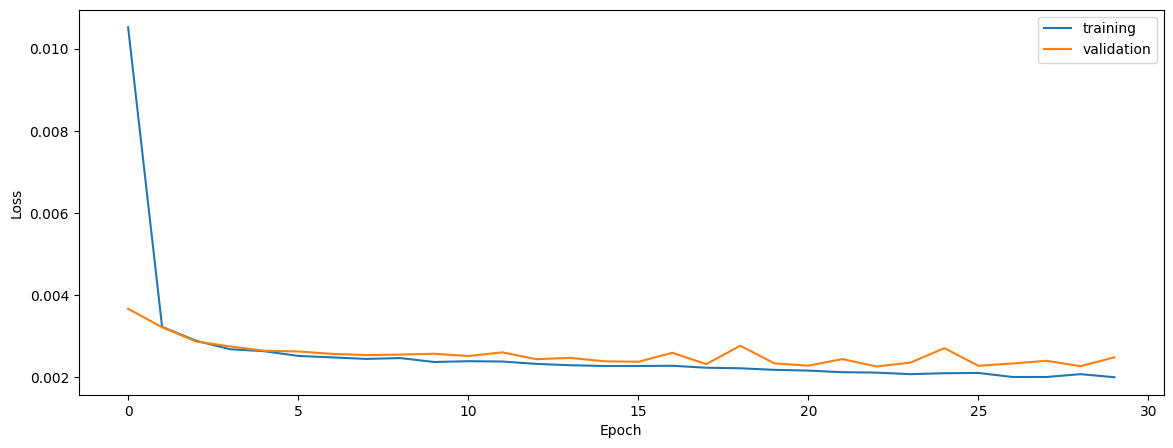

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9175911209894112
0.9188701028676802
0.9026593494308184


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.9175911209894112
0.9188701028676802
0.9026593494308184


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.924856878826137
0.9230654932268945
0.9211623446674573


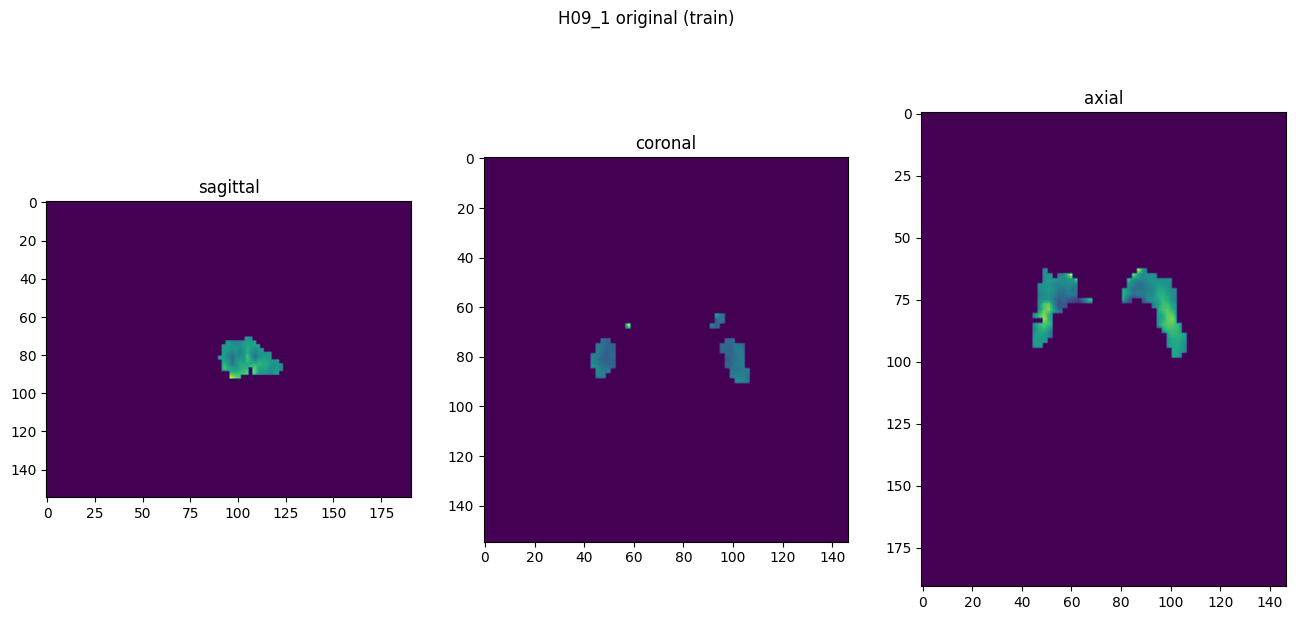

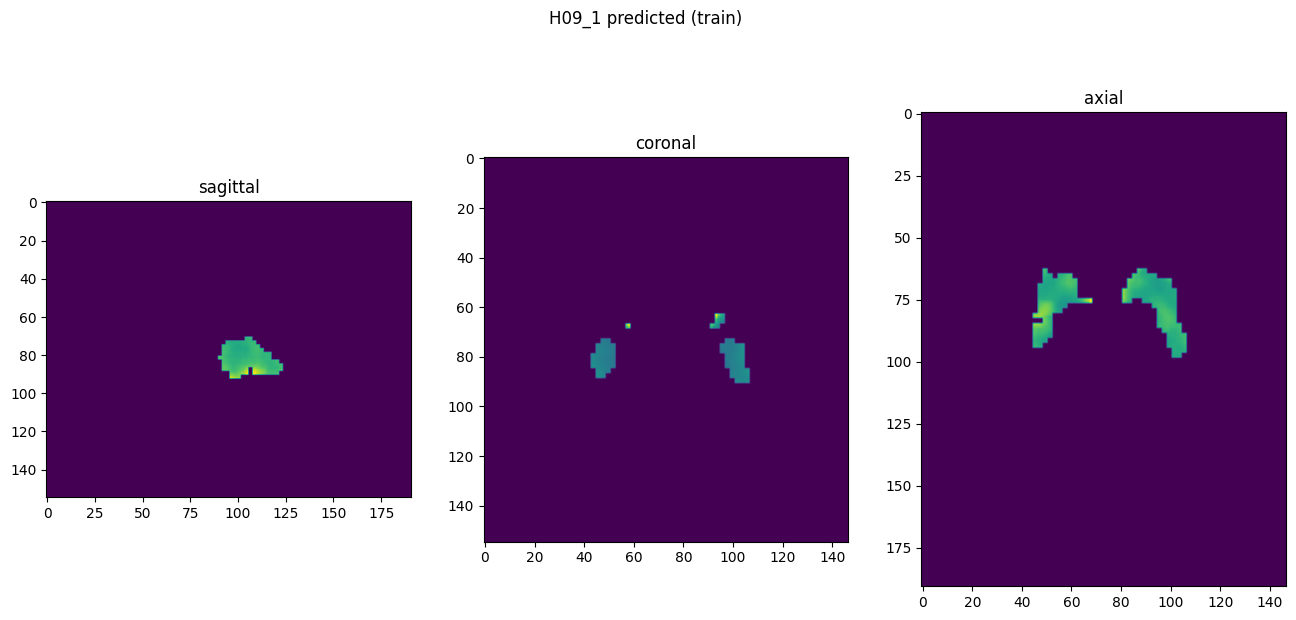

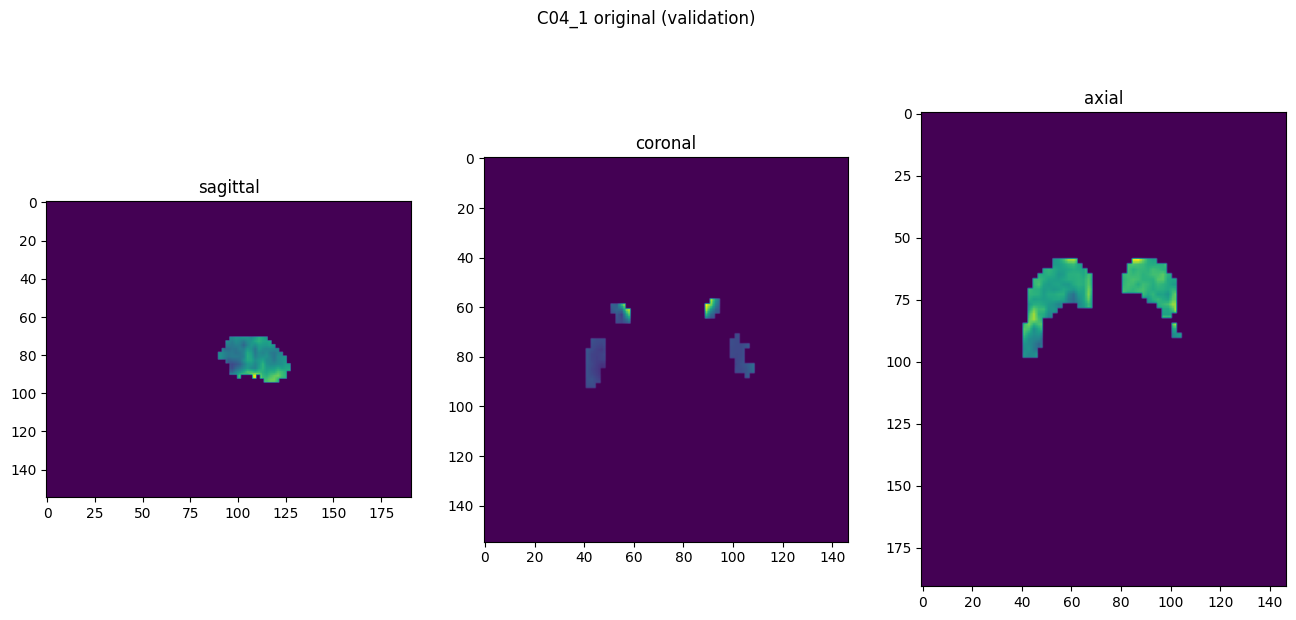

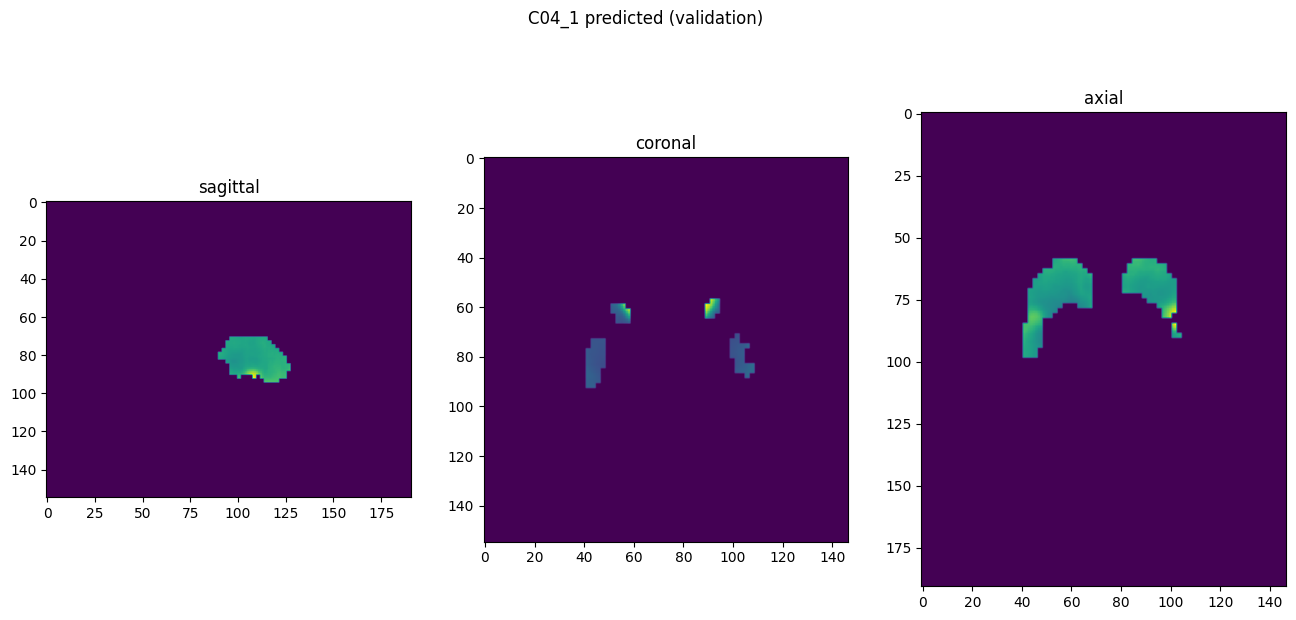

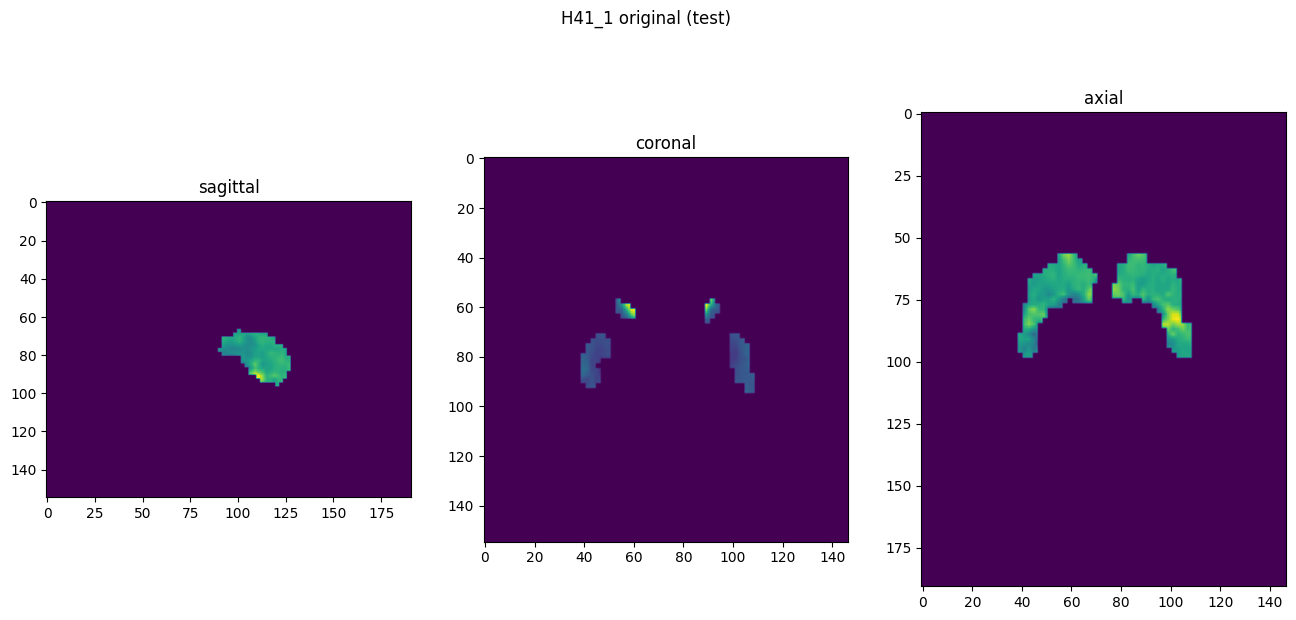

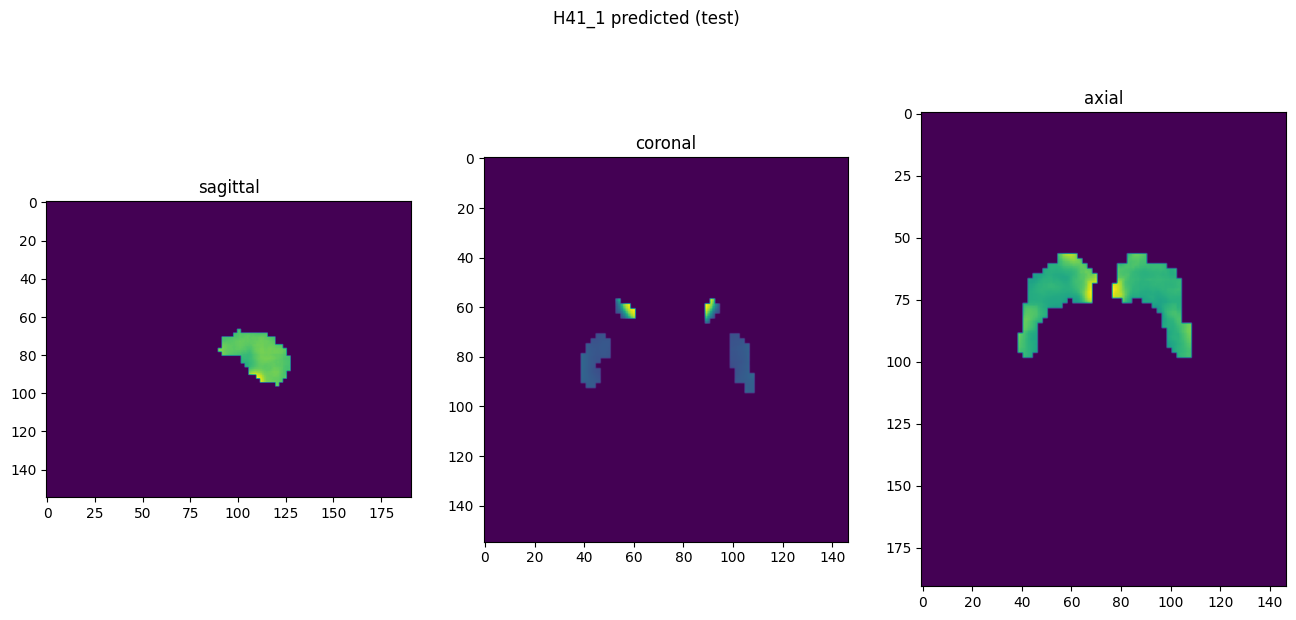

In [10]:
showResults(model, gen, threshold=None, background=False)